In [1]:
from itertools import combinations, product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr, pointbiserialr, rankdata
from scipy.stats.contingency import association
from tqdm.notebook import tqdm

# Corpus

In [3]:
corpus = pd.read_json('../../data/corpus.jsonl', lines=True)

In [4]:
corpus.columns

Index(['argument_id', 'argument', 'stance', 'topic', 'demographic_profile'], dtype='object')

In [11]:
corpus.topic.unique()

array(['Immigration', 'Society', 'Welfare', 'Education', 'Finances',
       'Economy', 'Security', 'Healthcare',
       'Infrastructure & Environment', 'Digitisation', 'Foreign Policy',
       'Political System'], dtype=object)

In [12]:
corpus.head()

,argument_id,argument,stance,topic,demographic_profile
0,201900,Das Schweizer Volk hat die MEI angenommen und ...,FAVOR,Immigration,"{'gender': 'Männlich', 'age': '18-34', 'reside..."
1,201901,Eine Legalisierung von Cannabis entlasten die ...,FAVOR,Society,"{'gender': 'Männlich', 'age': '18-34', 'reside..."
2,201902,Durch die Förderung der familienergänzenden Be...,FAVOR,Welfare,"{'gender': 'Weiblich', 'age': '35-49', 'reside..."
3,201903,Ich ziehe eine Elternzeit vor. Die Zeit nach d...,AGAINST,Welfare,"{'gender': 'Weiblich', 'age': '35-49', 'reside..."
4,201904,Unser Asylrecht muss konsequent angewendet wer...,AGAINST,Immigration,"{'gender': 'Weiblich', 'age': '35-49', 'reside..."


Unrolling the demographic profile into individual columns

In [5]:
for key in corpus.head().demographic_profile[4].keys():
    corpus[f"{key}"] = corpus.demographic_profile.apply(lambda x: x[f"{key}"])
corpus.head()

,argument_id,argument,stance,topic,demographic_profile,gender,age,residence,civil_status,denomination,education,political_spectrum,important_political_issues
0,201900,Das Schweizer Volk hat die MEI angenommen und ...,FAVOR,Immigration,"{'gender': 'Männlich', 'age': '18-34', 'reside...",Männlich,18-34,Land,Ledig,Christ-katholisch,Fachhochschule,Mitte und Konservativ-Liberal,"[Liberale Wirtschaftspolitik, Restriktive Migr..."
1,201901,Eine Legalisierung von Cannabis entlasten die ...,FAVOR,Society,"{'gender': 'Männlich', 'age': '18-34', 'reside...",Männlich,18-34,Land,Ledig,Christ-katholisch,Fachhochschule,Mitte und Konservativ-Liberal,"[Liberale Wirtschaftspolitik, Restriktive Migr..."
2,201902,Durch die Förderung der familienergänzenden Be...,FAVOR,Welfare,"{'gender': 'Weiblich', 'age': '35-49', 'reside...",Weiblich,35-49,Land,Ledig,Nicht bekannt,Universität,Mitte und Konservativ,"[Offene Aussenpolitik, Liberale Wirtschaftspol..."
3,201903,Ich ziehe eine Elternzeit vor. Die Zeit nach d...,AGAINST,Welfare,"{'gender': 'Weiblich', 'age': '35-49', 'reside...",Weiblich,35-49,Land,Ledig,Nicht bekannt,Universität,Mitte und Konservativ,"[Offene Aussenpolitik, Liberale Wirtschaftspol..."
4,201904,Unser Asylrecht muss konsequent angewendet wer...,AGAINST,Immigration,"{'gender': 'Weiblich', 'age': '35-49', 'reside...",Weiblich,35-49,Land,Ledig,Nicht bekannt,Universität,Mitte und Konservativ,"[Offene Aussenpolitik, Liberale Wirtschaftspol..."


<Axes: >

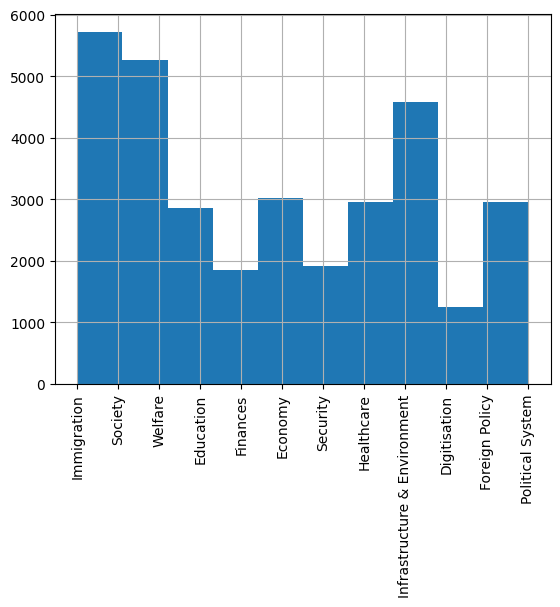

In [14]:
corpus.topic.hist(xrot=90)

Looking at how (un)balanced the dataset is, per stance overall and per topic.

<Axes: >

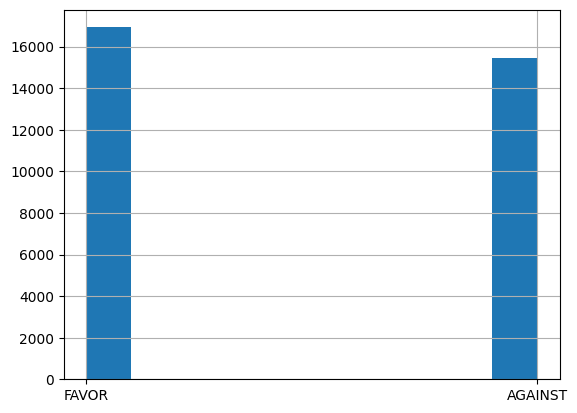

In [15]:
corpus.stance.hist()

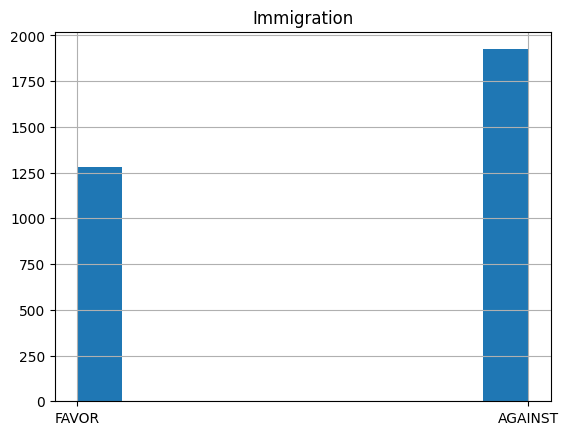

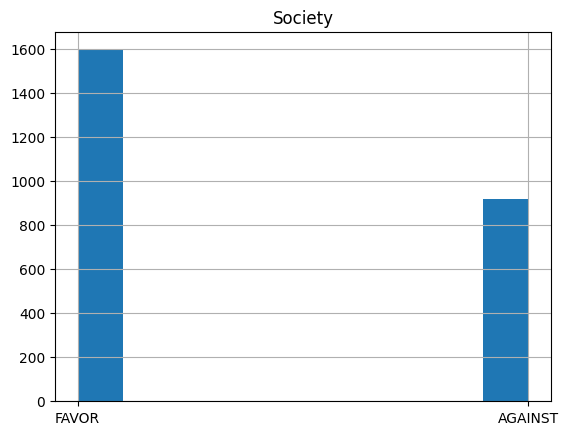

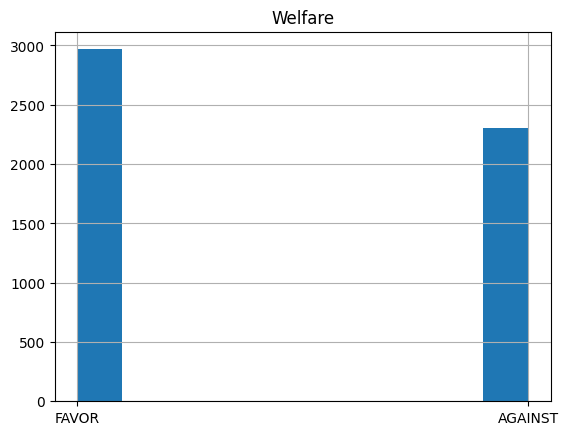

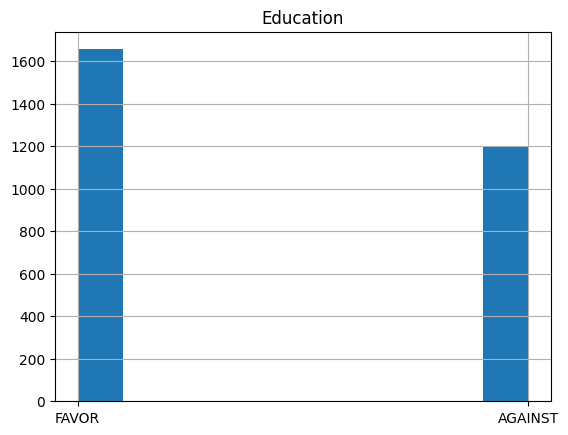

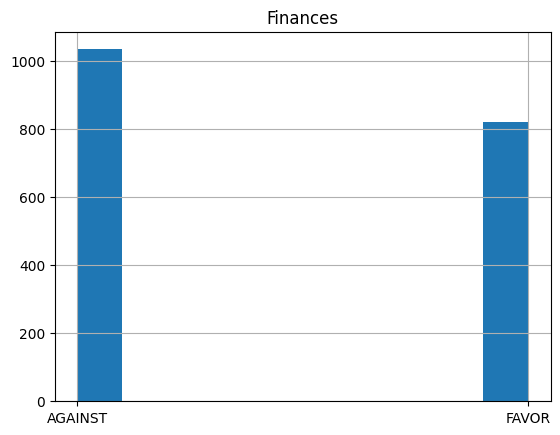

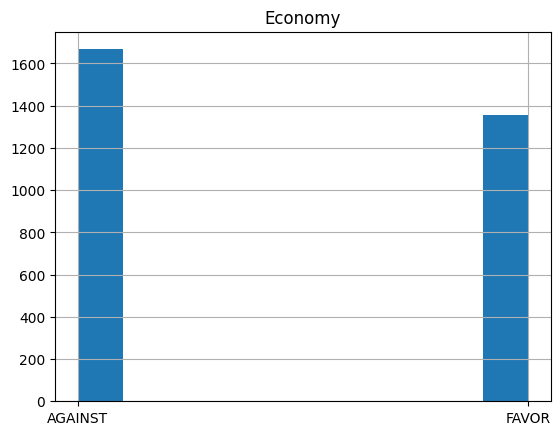

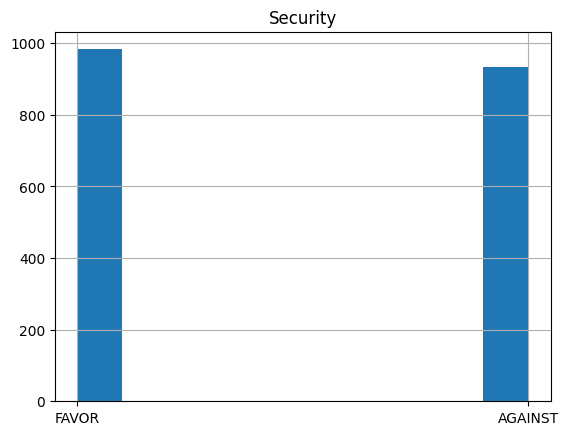

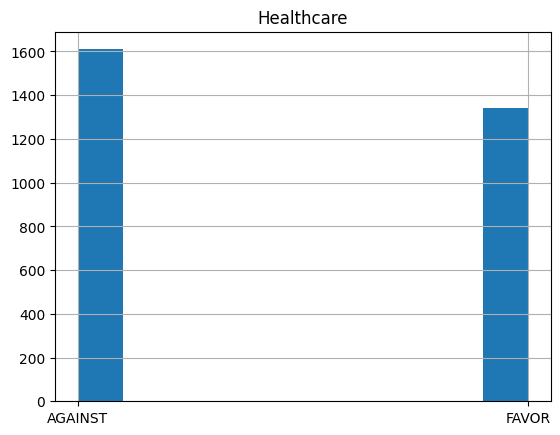

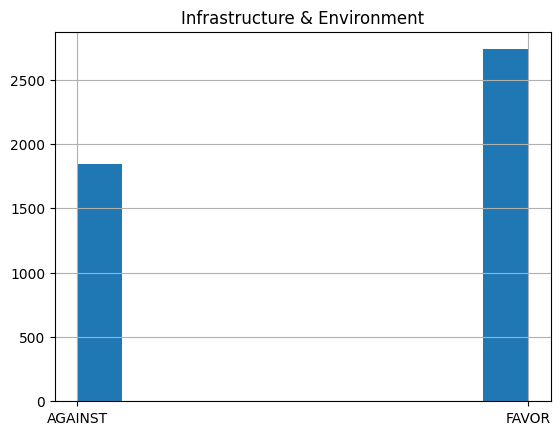

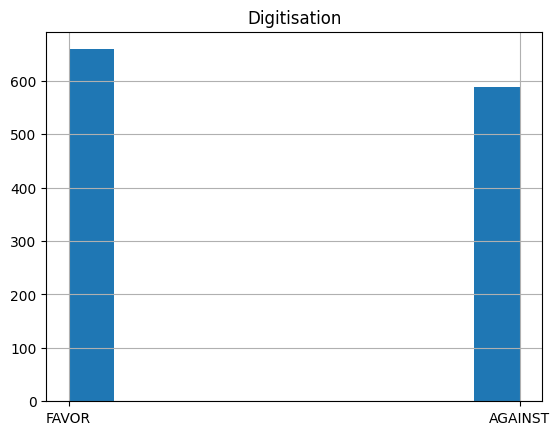

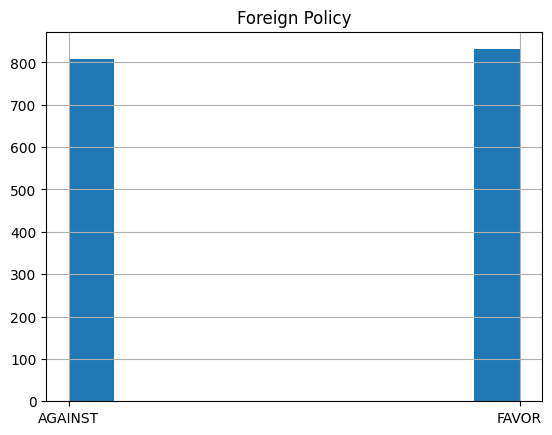

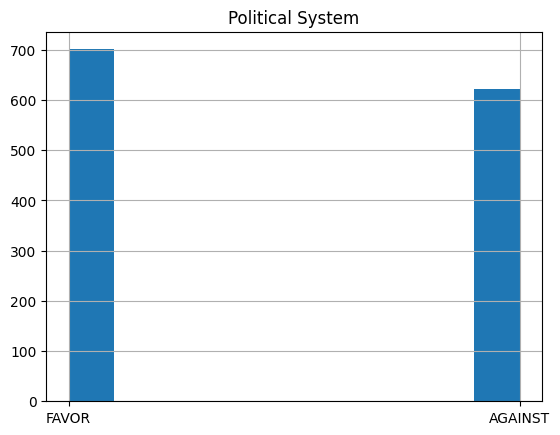

In [16]:
for i, tp in enumerate(corpus.topic.unique()):
    fig, ax = plt.subplots()
    corpus[corpus.topic == tp].stance.hist(ax=ax)
    ax.set_title(tp)
    plt.show()

Number of arguments per value, per sociodemographic attribute and topic.

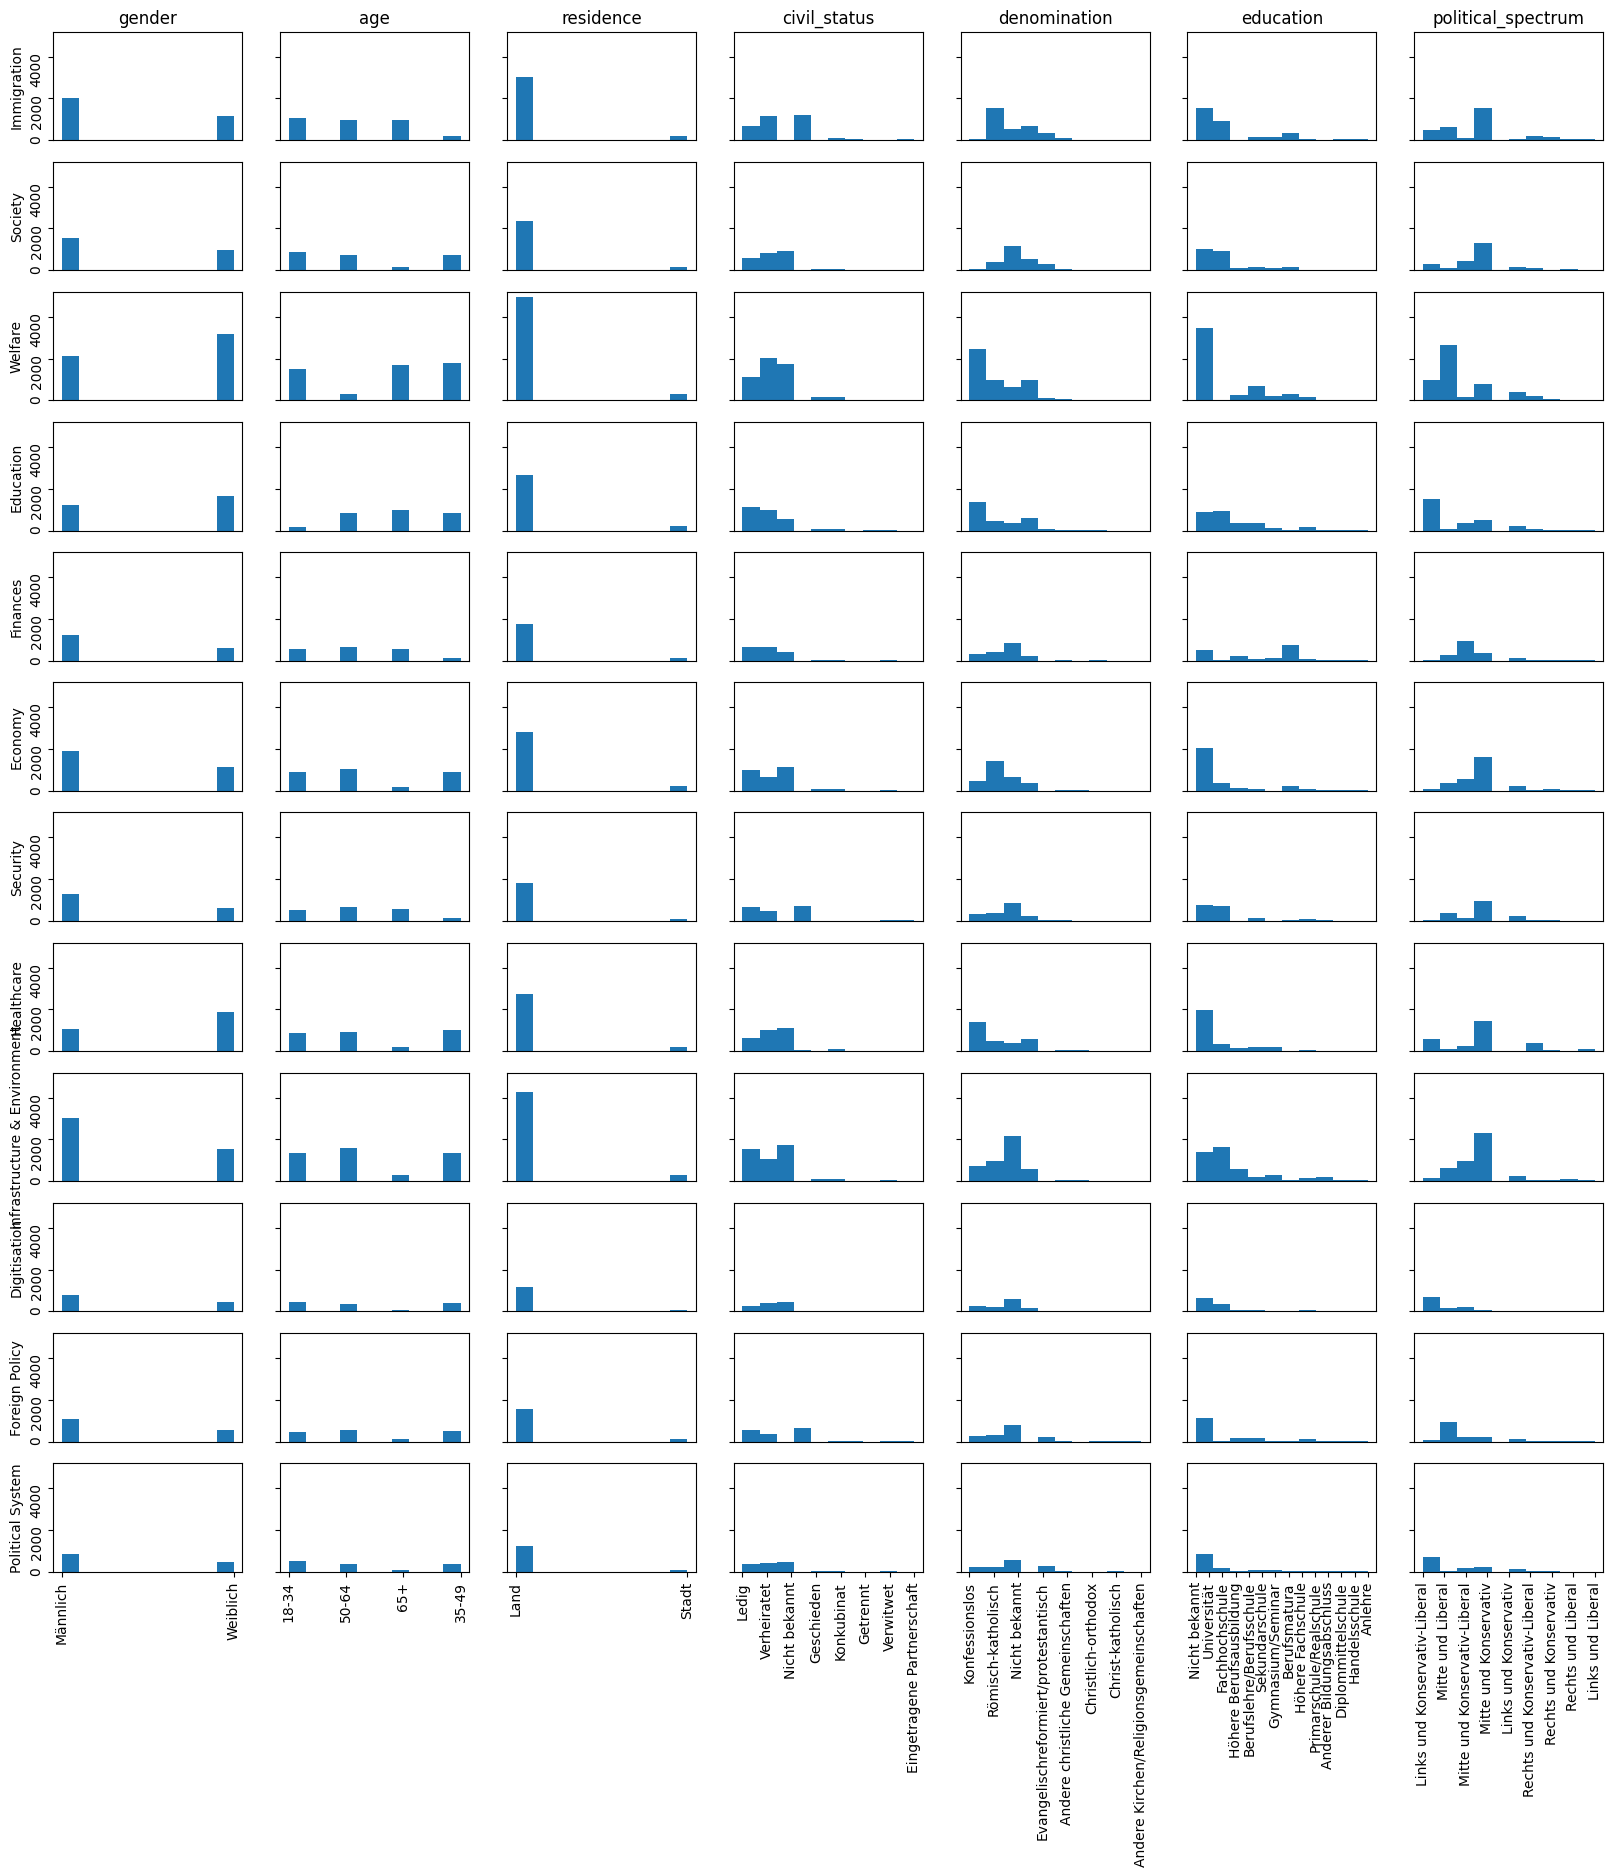

In [18]:
fig, ax = plt.subplots(ncols=7, nrows=12, figsize=(20,20), sharex=False, sharey=True)
for i, top in enumerate(corpus.topic.unique()):
    for j, attr in enumerate(['gender', 'age', 'residence', 'civil_status', 'denomination', 'education', 'political_spectrum']):
        ax[i,j].hist(corpus[corpus.topic == top][f"{attr}"])
        ax[i,j].set_xticklabels
        ax[i,j].tick_params(labelrotation=90)
        if i != 11:
            ax[i,j].set_xticks([], [])
        if i == 0:
            ax[i,j].set_title(f"{attr}")
        if j == 0:
            ax[i,j].set_ylabel(f"{top}")

Split into "FAVOR" and "AGAINST".

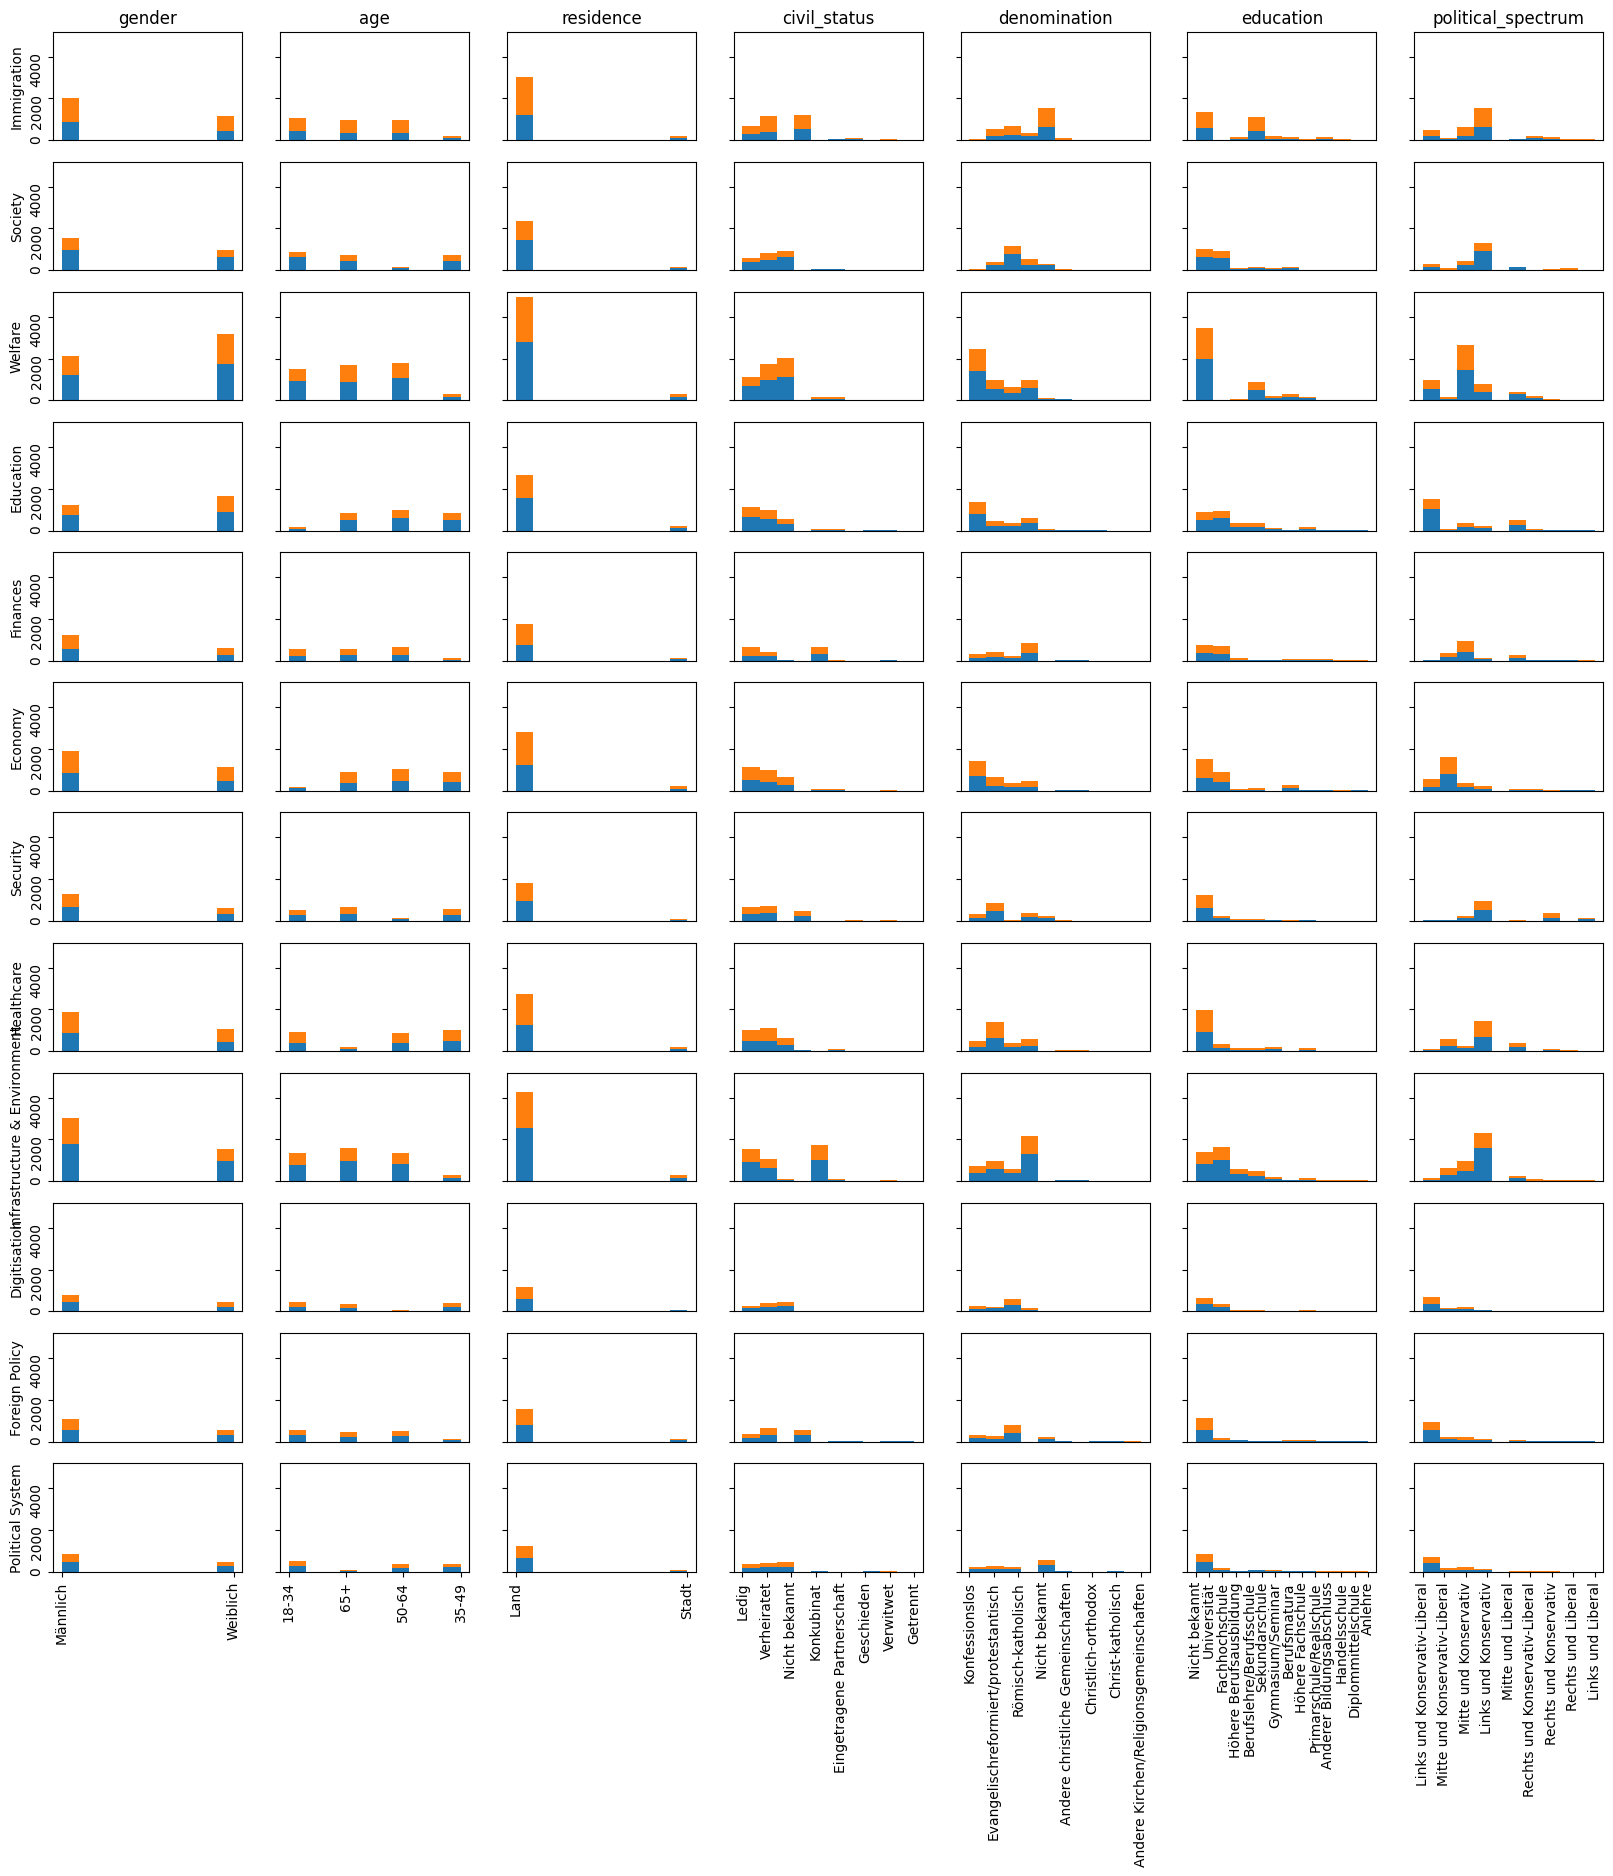

In [19]:
fig, ax = plt.subplots(ncols=7, nrows=12, figsize=(20,20), sharex=False, sharey=True)
for i, top in enumerate(corpus.topic.unique()):
    for j, attr in enumerate(['gender', 'age', 'residence', 'civil_status', 'denomination', 'education', 'political_spectrum']):
        ax[i,j].hist((corpus[(corpus.topic == top) & (corpus.stance == "FAVOR")][f"{attr}"], corpus[(corpus.topic == top) & (corpus.stance == "AGAINST")][f"{attr}"]), stacked=True)
        ax[i,j].set_xticklabels
        ax[i,j].tick_params(labelrotation=90)
        if i !=11:
            ax[i,j].set_xticks([], [])
        if i == 0:
            ax[i,j].set_title(f"{attr}")
        if j == 0:
            ax[i,j].set_ylabel(f"{top}")

Setting up profile IDs to look into individual profiles (combinations of specific value combinations of sociodemographic factors).

In [10]:
P_ID = {name:i for i, name in enumerate(corpus.demographic_profile.apply(lambda x: [x[attr] for attr in list(x.keys())[:-1]]).astype(str).unique())}

In [11]:
# For later retrieval of the groups
ID_P = {val:key for key, val in P_ID.items()}

In [22]:
len(P_ID)

1038

In [12]:
corpus["P_ID"] = corpus.demographic_profile.apply(lambda x: [x[attr] for attr in list(x.keys())[:-1]]).astype(str).apply(lambda x: P_ID[x])

Per topic, may there be a pattern in whether certain profiles are more often for/against a certain position?

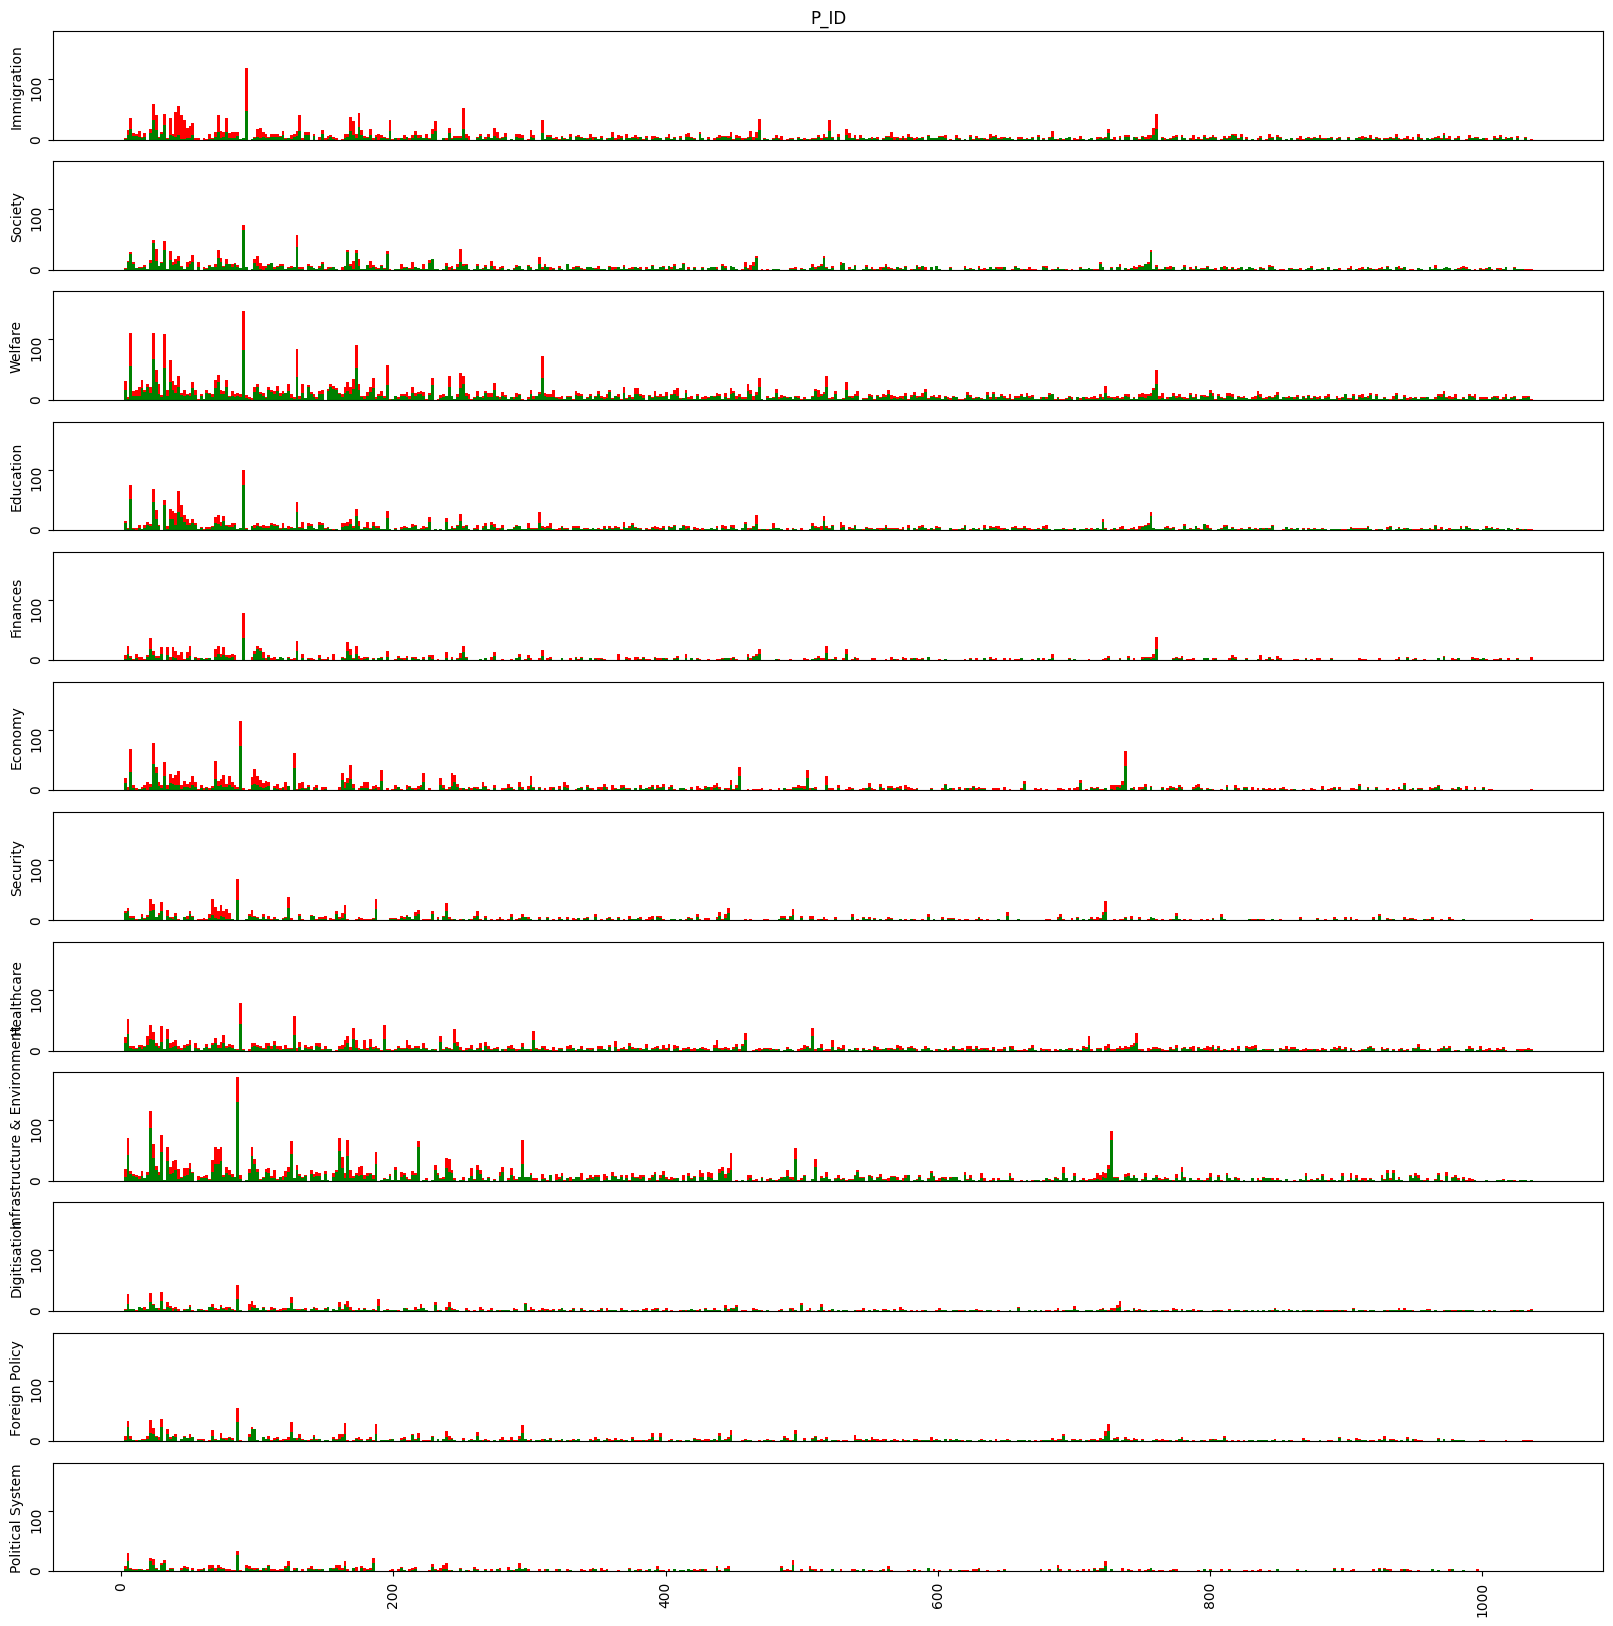

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=12, figsize=(20,20), sharex=False, sharey=True)
for i, top in enumerate(corpus.topic.unique()):
    for j, attr in enumerate(['P_ID']):
        ax[i].hist((corpus[(corpus.topic == top) & (corpus.stance == "FAVOR")][f"{attr}"], corpus[(corpus.topic == top) & (corpus.stance == "AGAINST")][f"{attr}"]), stacked=True, bins=500, color=["g","r"])
        ax[i].tick_params(labelrotation=90)
        if i !=11:
            ax[i].set_xticks([], [])
        if i == 0:
            ax[i].set_title(f"P_ID")
        if j == 0:
            ax[i].set_ylabel(f"{top}")

There are clear patterns of skewedness for certain subgroups in the immigration topic. We want to gather an insight which groups those are and what their commonalities might be. We thus calculate a favor salience per group and look at the groups over/under a certain threshold.

In [25]:
for top in corpus.topic.unique():
    print(top.upper())
    print("---------------------\n")
    for i in tqdm(corpus.P_ID.unique()):
        favor = len(corpus[(corpus.topic==top) & (corpus.P_ID == i) & (corpus.stance == "FAVOR")])
        against = len(corpus[(corpus.topic==top) & (corpus.P_ID == i) & (corpus.stance == "AGAINST")])
        if (favor+against) > 25:
            sal = favor/(favor+against)
            if sal < 0.5:
                print(ID_P[i], sal)

IMMIGRATION
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4722222222222222
['Männlich', '65+', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.46875
['Männlich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.20588235294117646
['Männlich', '50-64', 'Land', 'Verheiratet', 'Evangelischreformiert/protestantisch', 'Berufslehre/Berufsschule', 'Links und Konservativ-Liberal'] 0.10714285714285714
['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Fachhochschule', 'Links und Konservativ-Liberal'] 0.21621621621621623
['Weiblich', '50-64', 'Land', 'Verheiratet', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.0
['Männlich', '35-49', 'Land', 'Ledig', 'Römisch-katholisch', 'Universität', 'Mitte und Konservativ'] 0.34615384615384615
['Männlich', '35-49', 'Land', 'Verheiratet', 'Evangelischreformiert/protest

  0%|          | 0/1038 [00:00<?, ?it/s]

WELFARE
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4666666666666667
['Männlich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.45098039215686275
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.46774193548387094
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Mitte und Konservativ'] 0.46153846153846156
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.43636363636363634
['Männlich', '50-64', 'Land', 'Verheiratet', 'Evangelischreformiert/protestantisch', 'Universität', 'Mitte und Konservativ'] 0.4444444444444444
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Mitte und Konservativ-Liberal'] 0.4915254237288136
EDUCATION
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Fachhochschule', 'Links und Konservativ-Liberal'] 0.3953488372093023
FINANCES
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4605263157894737
['Weiblich', '50-64', 'Land', 'Verheiratet', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.47058823529411764
ECONOMY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.423728813559322
['Weiblich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.48936170212765956
['Männlich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4230769230769231
['Männlich', '35-49', 'Land', 'Ledig', 'Römisch-katholisch', 'Universität', 'Mitte und Konservativ'] 0.4230769230769231
['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.4594594594594595
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.47058823529411764
SECURITY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.48484848484848486
['Weiblich', '50-64', 'Land', 'Verheiratet', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.4482758620689655
HEALTHCARE
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.43902439024390244
['Weiblich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.38461538461538464
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.40425531914893614
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.46511627906976744
['Weiblich', '50-64', 'Land', 'Verheiratet', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.42857142857142855
INFRASTRUCTURE & ENVIRONMENT
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Männlich', '35-49', 'Land', 'Ledig', 'Römisch-katholisch', 'Universität', 'Mitte und Konservativ'] 0.4
['Männlich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Mitte und Konservativ-Liberal'] 0.42857142857142855
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Mitte und Konservativ-Liberal'] 0.3770491803278688
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Mitte und Konservativ-Liberal'] 0.391304347826087
DIGITISATION
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4230769230769231
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4523809523809524
FOREIGN POLICY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.36363636363636365
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.4827586206896552
['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.39285714285714285
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.4074074074074074
POLITICAL SYSTEM
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

In [26]:
for top in corpus.topic.unique():
    print(top.upper())
    print("---------------------\n")
    for i in tqdm(corpus.P_ID.unique()):
        favor = len(corpus[(corpus.topic==top) & (corpus.P_ID == i) & (corpus.stance == "FAVOR")])
        against = len(corpus[(corpus.topic==top) & (corpus.P_ID == i) & (corpus.stance == "AGAINST")])
        if (favor+against) > 25:
            sal = favor/(favor+against)
            if sal > 0.65 and sal < 1:
                print(ID_P[i], sal)

IMMIGRATION
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

SOCIETY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.8666666666666667
['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.9166666666666666
['Weiblich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.6875
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.8873239436619719
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.6590909090909091
['Männlich', '18-34', 'Land', 'Ledig', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.9629629629629629
['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.8846153846153846
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Kon

  0%|          | 0/1038 [00:00<?, ?it/s]

['Männlich', '50-64', 'Land', 'Verheiratet', 'Evangelischreformiert/protestantisch', 'Universität', 'Links und Konservativ-Liberal'] 0.6923076923076923
['Männlich', '35-49', 'Land', 'Ledig', 'Römisch-katholisch', 'Universität', 'Mitte und Konservativ'] 0.7037037037037037
EDUCATION
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.6825396825396826
['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.6984126984126984
['Weiblich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.82
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.7604166666666666
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.7222222222222222
['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.71875
['Weiblich', '50-64', 'Land', 'Verheiratet', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.8275862068965517
FINANCES
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

ECONOMY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Männlich', '65+', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.7307692307692307
['Männlich', '18-34', 'Land', 'Ledig', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.6538461538461539
['Männlich', '18-34', 'Land', 'Ledig', 'Konfessionslos', 'Universität', 'Links und Konservativ-Liberal'] 0.6774193548387096
SECURITY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

HEALTHCARE
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

INFRASTRUCTURE & ENVIRONMENT
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.7757009345794392
['Männlich', '65+', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.6808510638297872
['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.7619047619047619
['Männlich', '18-34', 'Land', 'Ledig', 'Evangelischreformiert/protestantisch', 'Universität', 'Links und Konservativ-Liberal'] 0.7142857142857143
['Männlich', '50-64', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.7096774193548387
['Männlich', '18-34', 'Land', 'Ledig', 'Nicht bekannt', 'Universität', 'Links und Konservativ-Liberal'] 0.7719298245614035
['Weiblich', '35-49', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Fachhochschule', 'Links und Konservativ-Liberal'] 0.8979591836734694
['Männlich', '35-49', 'Land', 'Verheiratet', 'Römisch-katholisch', 

  0%|          | 0/1038 [00:00<?, ?it/s]

FOREIGN POLICY
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Weiblich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.696969696969697
POLITICAL SYSTEM
---------------------



  0%|          | 0/1038 [00:00<?, ?it/s]

['Männlich', '18-34', 'Land', 'Nicht bekannt', 'Nicht bekannt', 'Nicht bekannt', 'Links und Konservativ-Liberal'] 0.8125


Splitting political spectrum into quasi-dimensions mapping to standard RILE and GALTAN

In [13]:
corpus[["rile", "galtan"]] = corpus.political_spectrum.str.split(" und ", expand=True)

In [28]:
corpus.head()

,argument_id,argument,stance,topic,demographic_profile,gender,age,residence,civil_status,denomination,education,political_spectrum,important_political_issues,P_ID,rile,galtan
0,201900,Das Schweizer Volk hat die MEI angenommen und ...,FAVOR,Immigration,"{'gender': 'Männlich', 'age': '18-34', 'reside...",Männlich,18-34,Land,Ledig,Christ-katholisch,Fachhochschule,Mitte und Konservativ-Liberal,"[Liberale Wirtschaftspolitik, Restriktive Migr...",0,Mitte,Konservativ-Liberal
1,201901,Eine Legalisierung von Cannabis entlasten die ...,FAVOR,Society,"{'gender': 'Männlich', 'age': '18-34', 'reside...",Männlich,18-34,Land,Ledig,Christ-katholisch,Fachhochschule,Mitte und Konservativ-Liberal,"[Liberale Wirtschaftspolitik, Restriktive Migr...",0,Mitte,Konservativ-Liberal
2,201902,Durch die Förderung der familienergänzenden Be...,FAVOR,Welfare,"{'gender': 'Weiblich', 'age': '35-49', 'reside...",Weiblich,35-49,Land,Ledig,Nicht bekannt,Universität,Mitte und Konservativ,"[Offene Aussenpolitik, Liberale Wirtschaftspol...",1,Mitte,Konservativ
3,201903,Ich ziehe eine Elternzeit vor. Die Zeit nach d...,AGAINST,Welfare,"{'gender': 'Weiblich', 'age': '35-49', 'reside...",Weiblich,35-49,Land,Ledig,Nicht bekannt,Universität,Mitte und Konservativ,"[Offene Aussenpolitik, Liberale Wirtschaftspol...",1,Mitte,Konservativ
4,201904,Unser Asylrecht muss konsequent angewendet wer...,AGAINST,Immigration,"{'gender': 'Weiblich', 'age': '35-49', 'reside...",Weiblich,35-49,Land,Ledig,Nicht bekannt,Universität,Mitte und Konservativ,"[Offene Aussenpolitik, Liberale Wirtschaftspol...",1,Mitte,Konservativ


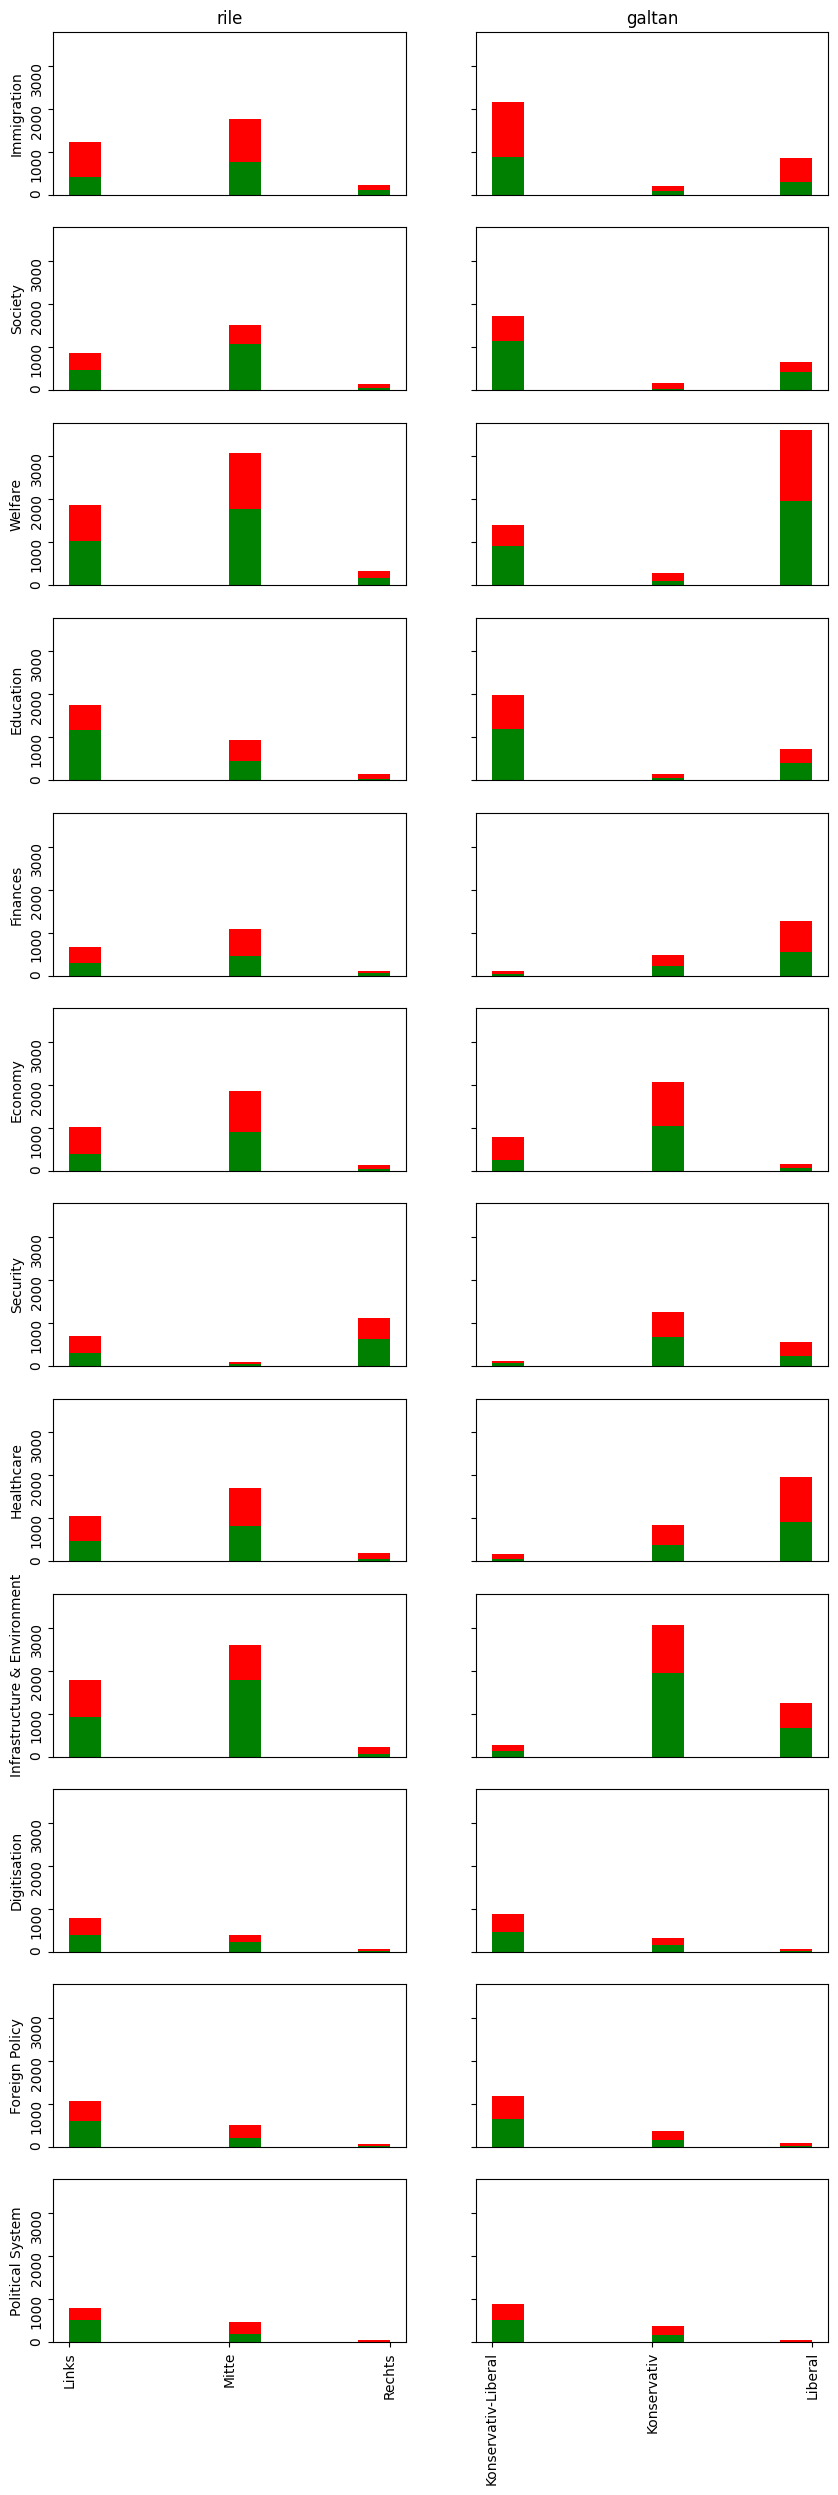

In [30]:
fig, ax = plt.subplots(ncols=2, nrows=12, figsize=(10,30), sharex=False, sharey=True)
for i, top in enumerate(corpus.topic.unique()):
    for j, attr in enumerate(['rile', "galtan"]):
        ax[i, j].hist((corpus[(corpus.topic == top) & (corpus.stance == "FAVOR")][f"{attr}"], corpus[(corpus.topic == top) & (corpus.stance == "AGAINST")][f"{attr}"]), stacked=True, color=["g","r"])
        ax[i, j].tick_params(labelrotation=90)
        if i !=11:
            ax[i, j].set_xticks([], [])
        if i == 0:
            ax[i, j].set_title(f"{attr}")
        if j == 0:
            ax[i, j].set_ylabel(f"{top}")

We have unknown values. How common are they per sociodemographic attribute and topic?

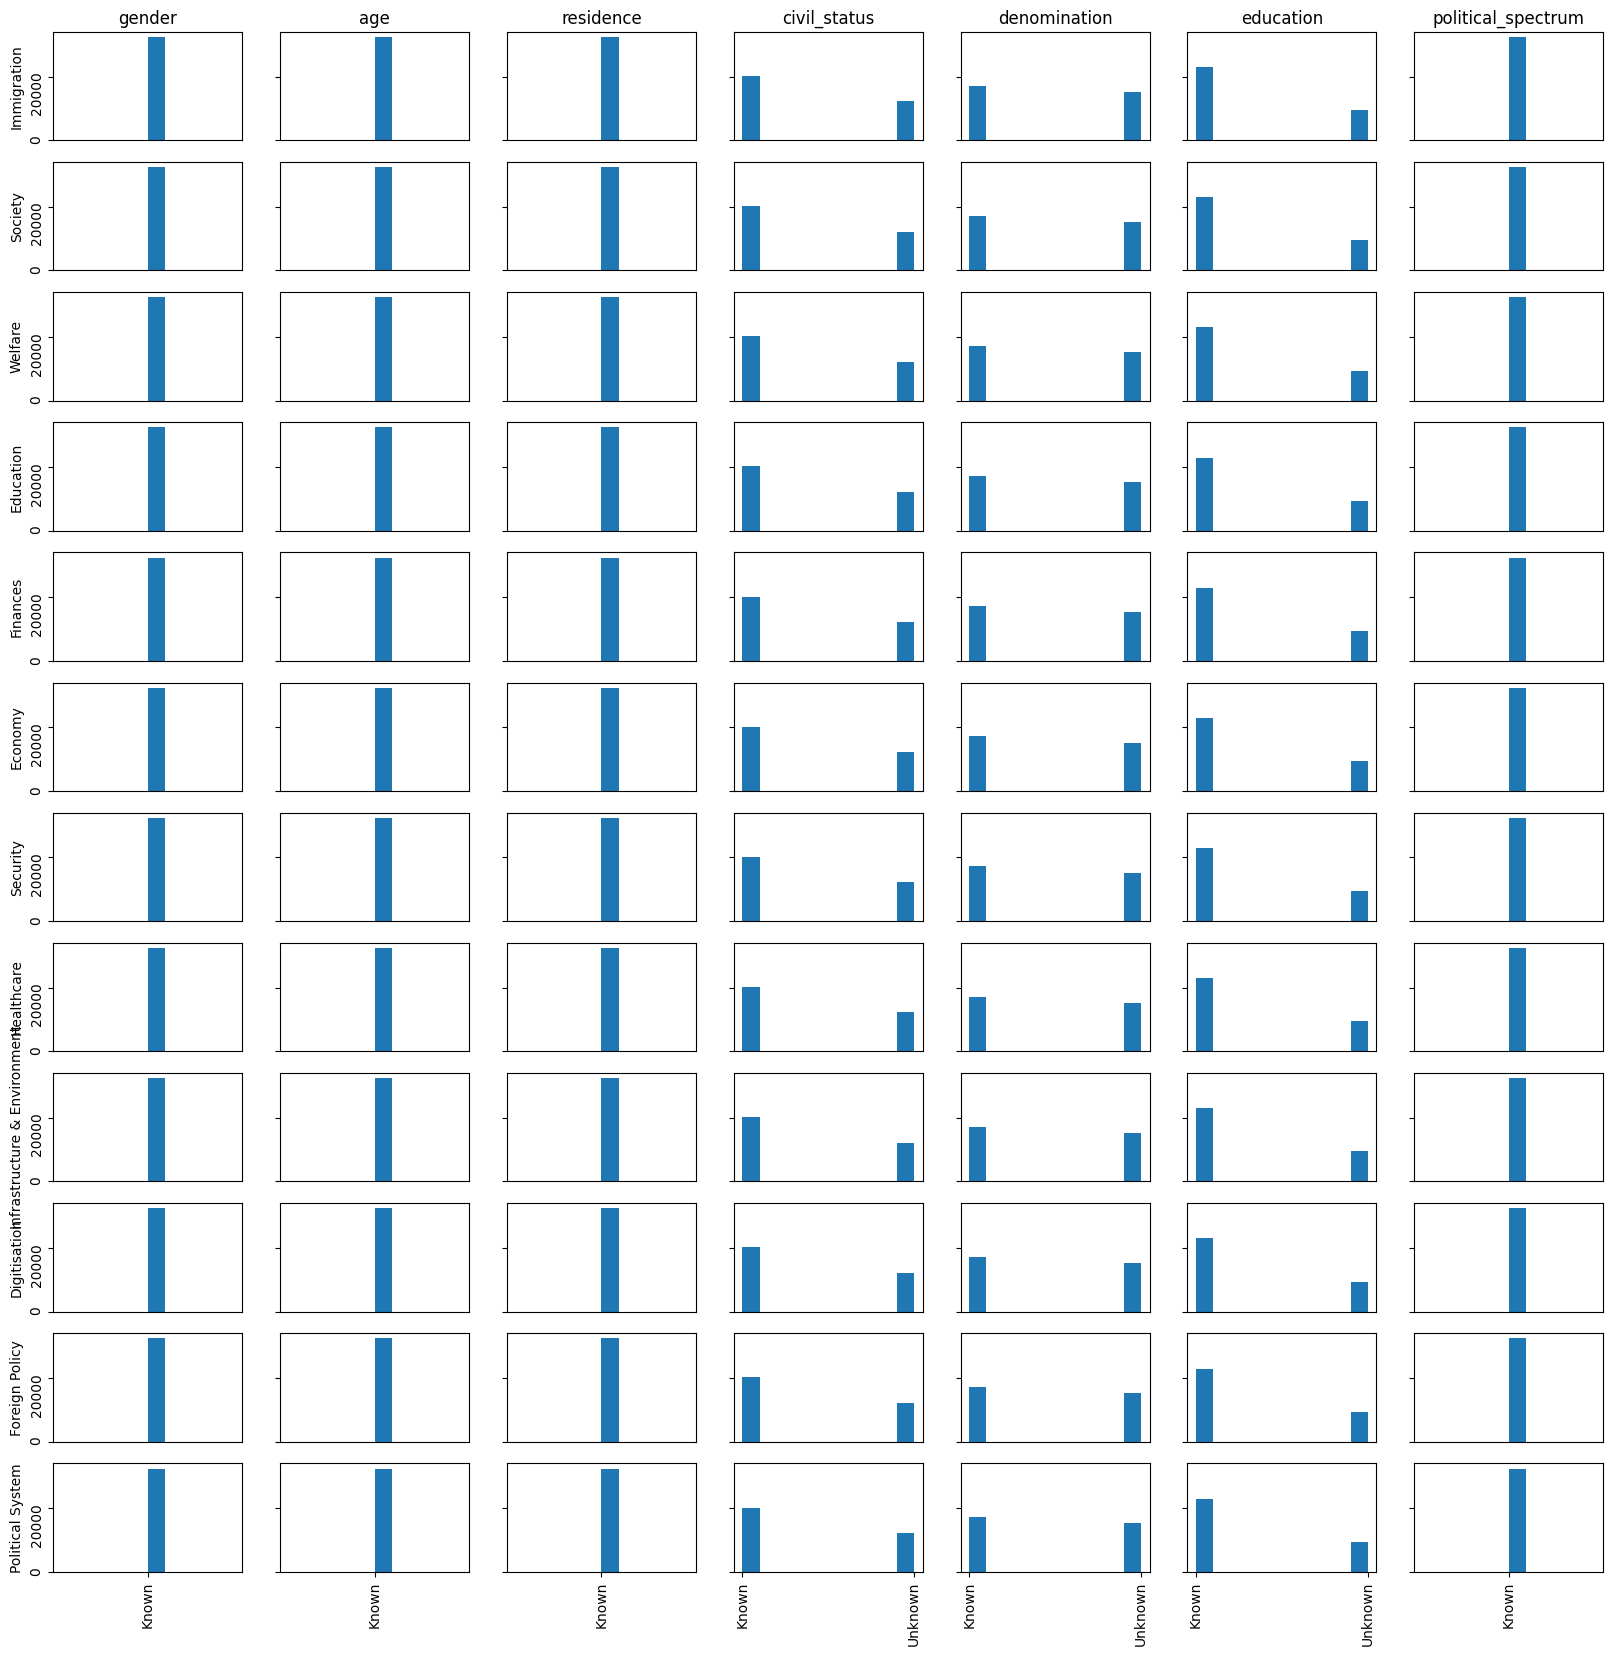

In [31]:
fig, ax = plt.subplots(ncols=7, nrows=12, figsize=(20,20), sharex=False, sharey=True)
for i, top in enumerate(corpus.topic.unique()):
    for j, attr in enumerate(['gender', 'age', 'residence', 'civil_status', 'denomination', 'education', 'political_spectrum']):
        ax[i,j].hist(corpus[f"{attr}"].apply(lambda x: "Unknown" if x=="Nicht bekannt" else "Known"))
        ax[i,j].set_xticklabels
        ax[i,j].tick_params(labelrotation=90)
        if i !=11:
            ax[i,j].set_xticks([], [])
        if i == 0:
            ax[i,j].set_title(f"{attr}")
        if j == 0:
            ax[i,j].set_ylabel(f"{top}")

In [199]:
corpus.columns

Index(['argument_id', 'argument', 'stance', 'topic', 'demographic_profile',
       'gender', 'age', 'residence', 'civil_status', 'denomination',
       'education', 'political_spectrum', 'important_political_issues', 'P_ID',
       'rile', 'galtan'],
      dtype='object')

In [224]:
corpus.galtan.unique()

array(['Konservativ-Liberal', 'Konservativ', 'Liberal'], dtype=object)

Looking into associations between attributes.

In [14]:
# nominal attributes
for col in ['stance', 'topic', 'gender', 'residence', 'civil_status', 'denomination', 'education', 'P_ID']:
    mapping = {val:i for i, val in enumerate(corpus[f"{col}"].unique())}
    corpus[f"{col}_num"] = corpus[f"{col}"].apply(lambda x: mapping[x])
# ordinal attributes
# age
mapping = {
    "18-34":0,
    "35-49":1,
    "50-64":2,
    "65+":3
}
corpus["age_num"] = corpus["age"].apply(lambda x: mapping[x])
# rile
mapping = {
    "Links":0,
    "Mitte":1,
    "Rechts":2
}
corpus["rile_num"] = corpus["rile"].apply(lambda x: mapping[x])
# galtan
mapping = {
    "Liberal":0,
    "Konservativ-Liberal":1,
    "Konservativ":2
}
corpus["galtan_num"] = corpus["galtan"].apply(lambda x: mapping[x])

In [15]:
corpus[['stance_num', 'topic_num', 'gender_num', 'age_num',
       'residence_num', 'civil_status_num', 'denomination_num',
       'education_num', 'rile_num', 'galtan_num']].corr(method="spearman")

,stance_num,topic_num,gender_num,age_num,residence_num,civil_status_num,denomination_num,education_num,rile_num,galtan_num
stance_num,1.000000,-0.013611,-0.011265,0.035122,-0.011910,0.022479,0.023881,0.010755,0.118872,0.001696
topic_num,-0.013611,1.000000,-0.033459,-0.011991,0.000581,-0.012549,0.000709,-0.011204,-0.022040,0.006008
gender_num,-0.011265,-0.033459,1.000000,0.051331,-0.022357,0.054641,-0.111514,0.047577,-0.189282,0.015775
age_num,0.035122,-0.011991,0.051331,1.000000,0.022433,0.471375,0.094770,0.043374,0.065364,-0.089868
residence_num,-0.011910,0.000581,-0.022357,0.022433,1.000000,-0.037615,0.004008,-0.023696,-0.032243,0.056648
civil_status_num,0.022479,-0.012549,0.054641,0.471375,-0.037615,1.000000,0.202154,-0.028894,0.006949,-0.037676
denomination_num,0.023881,0.000709,-0.111514,0.094770,0.004008,0.202154,1.000000,-0.042601,0.102354,0.037257
education_num,0.010755,-0.011204,0.047577,0.043374,-0.023696,-0.028894,-0.042601,1.000000,-0.051002,-0.143339
rile_num,0.118872,-0.022040,-0.189282,0.065364,-0.032243,0.006949,0.102354,-0.051002,1.000000,0.226191
galtan_num,0.001696,0.006008,0.015775,-0.089868,0.056648,-0.037676,0.037257,-0.143339,0.226191,1.000000


Nominal-Nominal Associations

In [34]:
for i, j in combinations(['stance_num', 'topic_num', 'gender_num',
       'residence_num', 'civil_status_num', 'denomination_num',
       'education_num'], 2):
       print(i, "\t\t", j, "\t\t",association(pd.crosstab(corpus[i], corpus[j])))

stance_num 		 topic_num 		 0.14363025090904236
stance_num 		 gender_num 		 0.011264546524466524
stance_num 		 residence_num 		 0.011909898179578585
stance_num 		 civil_status_num 		 0.03300656817866932
stance_num 		 denomination_num 		 0.05768873508171987
stance_num 		 education_num 		 0.03988894401151543
topic_num 		 gender_num 		 0.06050972188896854
topic_num 		 residence_num 		 0.013763192125892871
topic_num 		 civil_status_num 		 0.021587470457332194
topic_num 		 denomination_num 		 0.023224662287803115
topic_num 		 education_num 		 0.02314808025691455
gender_num 		 residence_num 		 0.0223570545214285
gender_num 		 civil_status_num 		 0.14741730673979367
gender_num 		 denomination_num 		 0.14401763773265663
gender_num 		 education_num 		 0.20417243181358105
residence_num 		 civil_status_num 		 0.13808142486999994
residence_num 		 denomination_num 		 0.1771594358419275
residence_num 		 education_num 		 0.11337088677633377
civil_status_num 		 denomination_num 		 0.28257685993175674
c

Ordinal-Ordinal Associations

In [35]:
for i, j in combinations(['age_num', 'rile_num', 'galtan_num'], 2):
    print(i, "\t\t", j, "\t\t",spearmanr(corpus[i], corpus[j]))

age_num 		 rile_num 		 SignificanceResult(statistic=0.06536409230096127, pvalue=5.232120159728322e-32)
age_num 		 galtan_num 		 SignificanceResult(statistic=-0.08986785623321362, pvalue=4.638223646400384e-59)
rile_num 		 galtan_num 		 SignificanceResult(statistic=0.22619121103587356, pvalue=0.0)


Ordinal-Norminal Associations

In [36]:
for j, i in product(['age_num', 'rile_num', 'galtan_num'], ['stance_num', 'topic_num', 'gender_num',
       'residence_num', 'civil_status_num', 'denomination_num',
       'education_num']):
       print(i, "\t\t", j, "\t\t", pointbiserialr(corpus[i], corpus[j]))

stance_num 		 age_num 		 SignificanceResult(statistic=0.033179182369939476, pvalue=2.3369049260147885e-09)
topic_num 		 age_num 		 SignificanceResult(statistic=-0.010862559012612648, pvalue=0.05060071373983393)
gender_num 		 age_num 		 SignificanceResult(statistic=0.03947277315355168, pvalue=1.1930853442636073e-12)
residence_num 		 age_num 		 SignificanceResult(statistic=0.01910344424024085, pvalue=0.0005857873747594515)
civil_status_num 		 age_num 		 SignificanceResult(statistic=0.43622377311021143, pvalue=0.0)
denomination_num 		 age_num 		 SignificanceResult(statistic=0.0869676011592538, pvalue=2.0680535862599143e-55)
education_num 		 age_num 		 SignificanceResult(statistic=0.01763516268446142, pvalue=0.001504486763762322)
stance_num 		 rile_num 		 SignificanceResult(statistic=0.11939592835518781, pvalue=3.972786262323636e-103)
topic_num 		 rile_num 		 SignificanceResult(statistic=-0.024865534720681426, pvalue=7.6262167304205115e-06)
gender_num 		 rile_num 		 SignificanceResult(stat

## Coarse-grained taxonomy

In [6]:
civil_status_coarse = {
    'Ledig':'unpartnered',
    'Verheiratet':'partnered',
    'Geschieden':'unpartnered',
    'Verwitwet':'unpartnered',
    'Konkubinat':'partnered',
    'Aufgelöste Partnerschaft':'unpartnered',
    'Eingetragene Partnerschaft':'partnered',
    'Getrennt':'unpartnered',
    'Nicht bekannt':'unknown'
}

religiousness_coarse = {
    'Christ-katholisch':'christian',
    'Römisch-katholisch':'christian',
    'Konfessionslos':'not religious',
    'Evangelischreformiert/protestantisch':'christian',
    'Andere christliche Gemeinschaften':'christian',
    'Christlich-orthodox':'christian',
    'Andere Kirchen/Religionsgemeinschaften':'not christian',
    'Islamische Gemeinschaften':'not christian',
    'Jüdische Gemeinschaften':'not christian',
    'Nicht bekannt':'unknown'
}

education_level_coarse = {
    'Fachhochschule':'tertiary',
    'Universität':'tertiary',
    'Nicht bekannt':'unknown',
    'Handelsschule':'secondary',
    'Höhere Berufsausbildung':'tertiary',
    'Berufsmatura':'secondary',
    'Gymnasium/Seminar':'secondary',
    'Berufslehre/Berufsschule':'secondary',
    'Höhere Fachschule':'tertiary',
    'Primarschule/Realschule':'secondary',
    'Anderer Bildungsabschluss':'unknown',
    'Diplommittelschule':'secondary',
    'Sekundarschule':'secondary',
    'Anlehre':'secondary'
}

corpus["education_coarse"] = corpus["education"].map(education_level_coarse)
corpus["civil_status_coarse"] = corpus["civil_status"].map(civil_status_coarse)
corpus["religiousness_coarse"] = corpus["denomination"].map(religiousness_coarse)

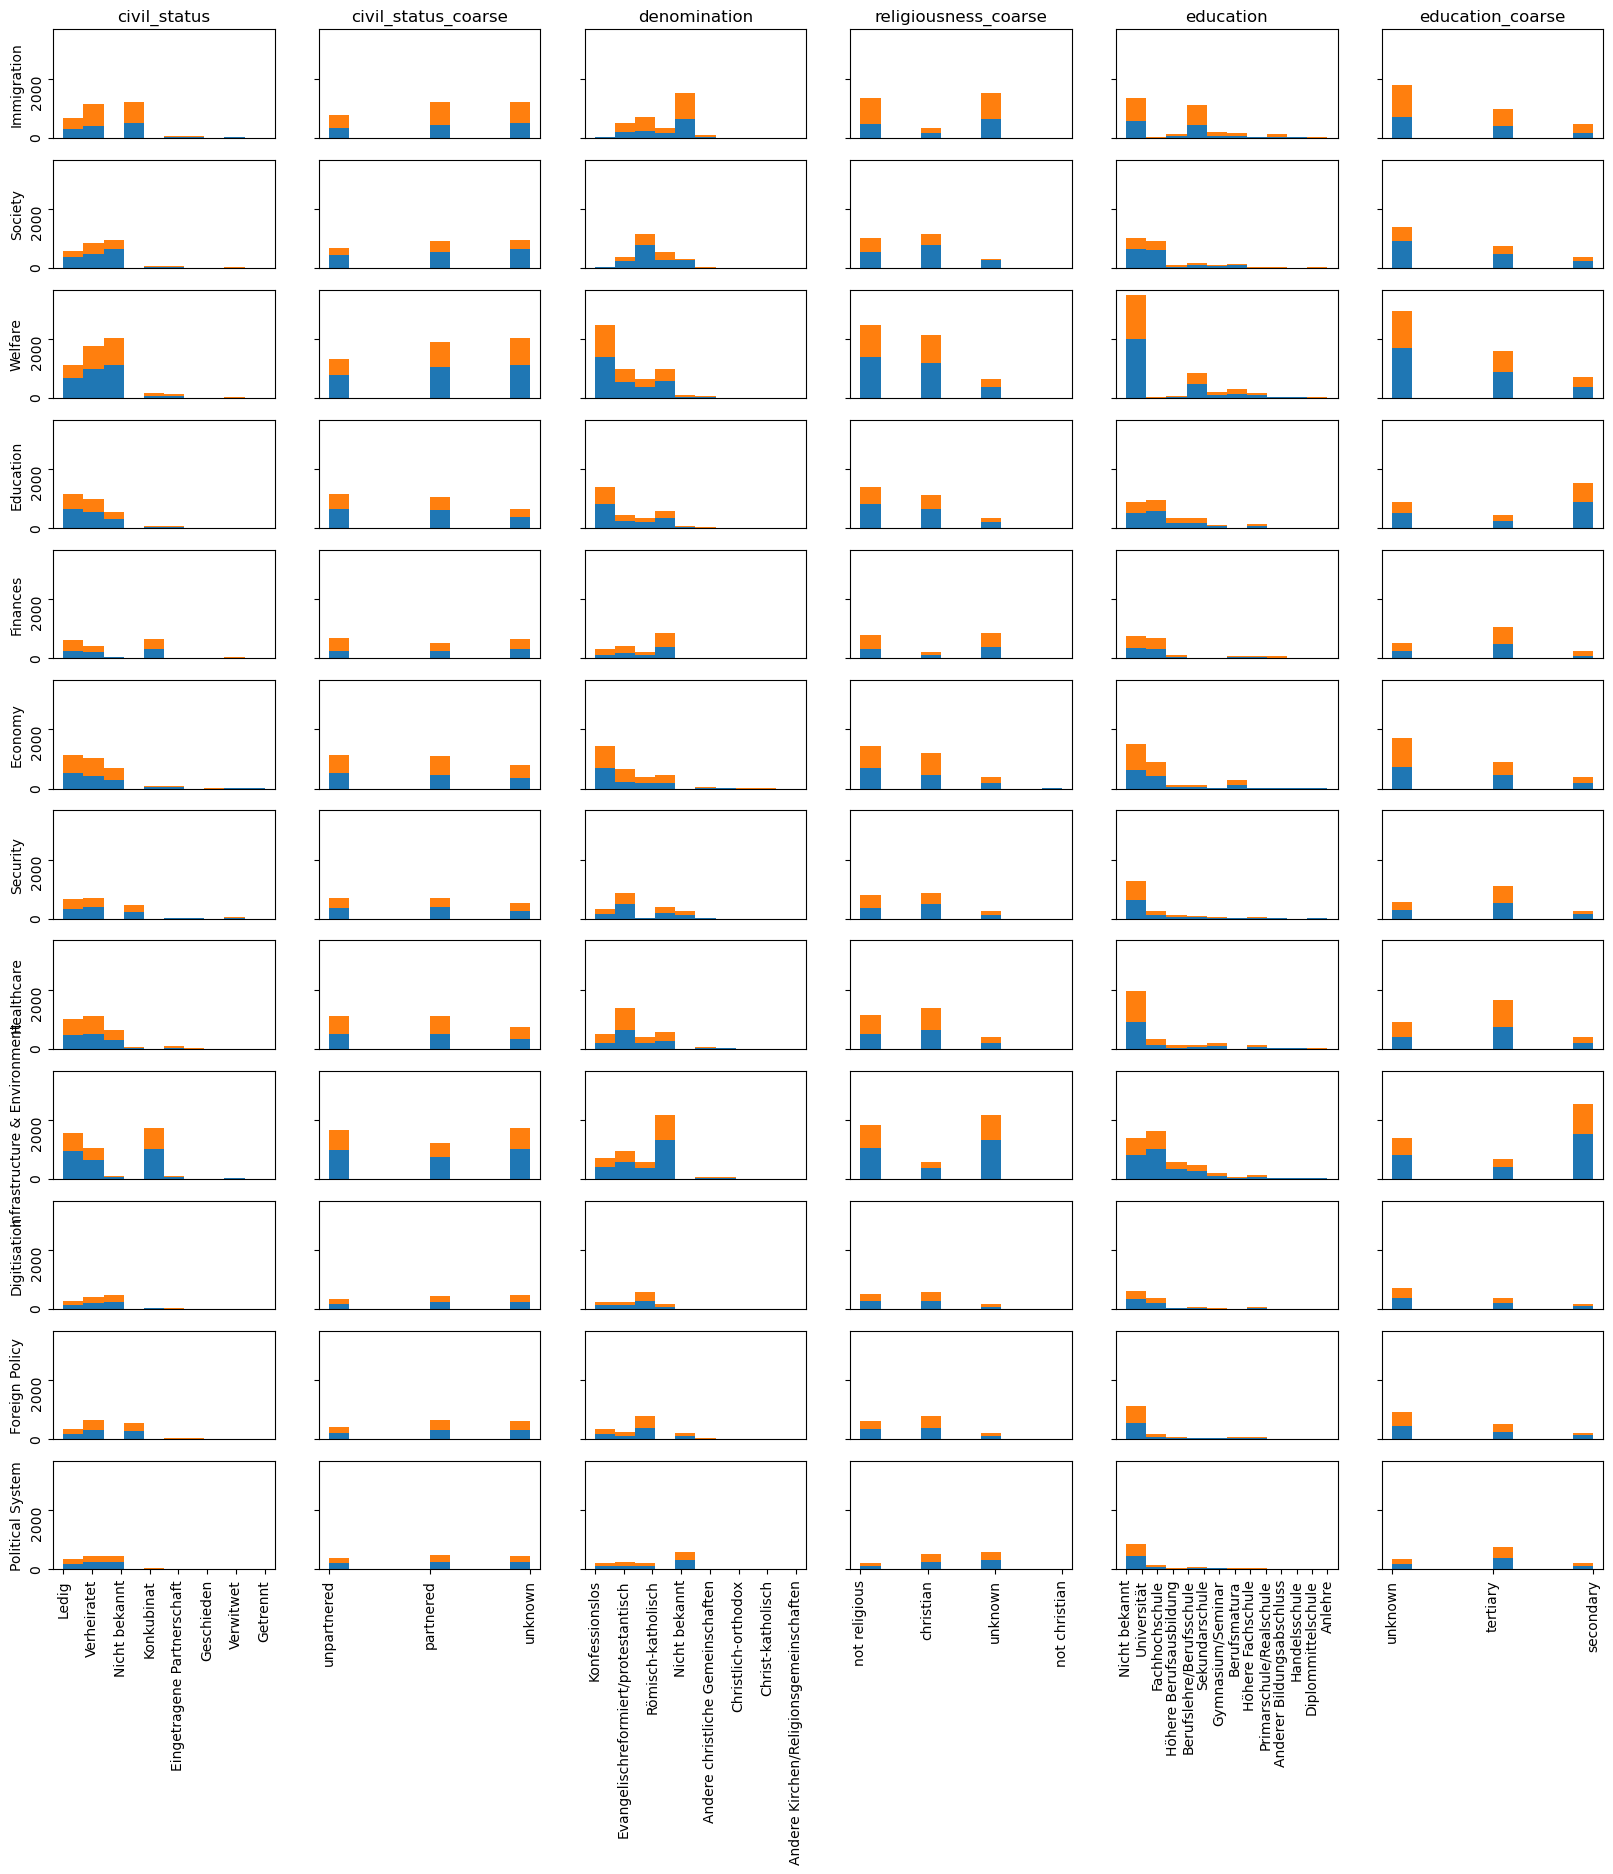

In [9]:
fig, ax = plt.subplots(ncols=6, nrows=12, figsize=(20,20), sharex=False, sharey=True)
for i, top in enumerate(corpus.topic.unique()):
    for j, attr in enumerate(['civil_status', 'civil_status_coarse', 'denomination', 'religiousness_coarse', 'education', 'education_coarse']):
        ax[i,j].hist((corpus[(corpus.topic == top) & (corpus.stance == "FAVOR")][f"{attr}"], corpus[(corpus.topic == top) & (corpus.stance == "AGAINST")][f"{attr}"]), stacked=True)
        ax[i,j].set_xticklabels
        ax[i,j].tick_params(labelrotation=90)
        if i !=11:
            ax[i,j].set_xticks([], [])
        if i == 0:
            ax[i,j].set_title(f"{attr}")
        if j == 0:
            ax[i,j].set_ylabel(f"{top}")

In [17]:
for col in ['civil_status_coarse', 'religiousness_coarse', 'education_coarse', 'P_ID']:
    mapping = {val:i for i, val in enumerate(corpus[f"{col}"].unique())}
    corpus[f"{col}_num"] = corpus[f"{col}"].apply(lambda x: mapping[x])

In [21]:
corr = corpus[['stance_num', 'topic_num', 'gender_num', 'age_num',
       'residence_num', 'civil_status_coarse_num', 'religiousness_coarse_num',
       'education_coarse_num', 'rile_num', 'galtan_num', 'civil_status_num',
       'denomination_num', 'education_num']].corr(method="spearman")

In [23]:
corpus[['stance_num', 'topic_num', 'gender_num', 'age_num',
       'residence_num', 'civil_status_coarse_num', 'religiousness_coarse_num',
       'education_coarse_num', 'rile_num', 'galtan_num']].corr(method="spearman").style.background_gradient(cmap='coolwarm')

,stance_num,topic_num,gender_num,age_num,residence_num,civil_status_coarse_num,religiousness_coarse_num,education_coarse_num,rile_num,galtan_num
stance_num,1.000000,-0.013611,-0.011265,0.035122,-0.011910,0.025343,-0.049098,-0.004710,0.118872,0.001696
topic_num,-0.013611,1.000000,-0.033459,-0.011991,0.000581,-0.009493,0.019493,-0.001606,-0.022040,0.006008
gender_num,-0.011265,-0.033459,1.000000,0.051331,-0.022357,0.021756,-0.008094,-0.010459,-0.189282,0.015775
age_num,0.035122,-0.011991,0.051331,1.000000,0.022433,0.378002,-0.199070,-0.022486,0.065364,-0.089868
residence_num,-0.011910,0.000581,-0.022357,0.022433,1.000000,-0.017584,0.138328,-0.019259,-0.032243,0.056648
civil_status_coarse_num,0.025343,-0.009493,0.021756,0.378002,-0.017584,1.000000,-0.191460,-0.113774,0.011698,-0.048075
religiousness_coarse_num,-0.049098,0.019493,-0.008094,-0.199070,0.138328,-0.191460,1.000000,0.043604,-0.155799,-0.002303
education_coarse_num,-0.004710,-0.001606,-0.010459,-0.022486,-0.019259,-0.113774,0.043604,1.000000,-0.049512,-0.134087
rile_num,0.118872,-0.022040,-0.189282,0.065364,-0.032243,0.011698,-0.155799,-0.049512,1.000000,0.226191
galtan_num,0.001696,0.006008,0.015775,-0.089868,0.056648,-0.048075,-0.002303,-0.134087,0.226191,1.000000


In [24]:
corpus[['stance_num', 'topic_num', 'gender_num', 'age_num',
       'residence_num', 'civil_status_num',
       'denomination_num', 'education_num', 'rile_num', 'galtan_num']].corr(method="spearman").style.background_gradient(cmap='coolwarm')

,stance_num,topic_num,gender_num,age_num,residence_num,civil_status_num,denomination_num,education_num,rile_num,galtan_num
stance_num,1.000000,-0.013611,-0.011265,0.035122,-0.011910,0.022479,0.023881,0.010755,0.118872,0.001696
topic_num,-0.013611,1.000000,-0.033459,-0.011991,0.000581,-0.012549,0.000709,-0.011204,-0.022040,0.006008
gender_num,-0.011265,-0.033459,1.000000,0.051331,-0.022357,0.054641,-0.111514,0.047577,-0.189282,0.015775
age_num,0.035122,-0.011991,0.051331,1.000000,0.022433,0.471375,0.094770,0.043374,0.065364,-0.089868
residence_num,-0.011910,0.000581,-0.022357,0.022433,1.000000,-0.037615,0.004008,-0.023696,-0.032243,0.056648
civil_status_num,0.022479,-0.012549,0.054641,0.471375,-0.037615,1.000000,0.202154,-0.028894,0.006949,-0.037676
denomination_num,0.023881,0.000709,-0.111514,0.094770,0.004008,0.202154,1.000000,-0.042601,0.102354,0.037257
education_num,0.010755,-0.011204,0.047577,0.043374,-0.023696,-0.028894,-0.042601,1.000000,-0.051002,-0.143339
rile_num,0.118872,-0.022040,-0.189282,0.065364,-0.032243,0.006949,0.102354,-0.051002,1.000000,0.226191
galtan_num,0.001696,0.006008,0.015775,-0.089868,0.056648,-0.037676,0.037257,-0.143339,0.226191,1.000000


Nominal-nominal associations

In [25]:
for i, j in combinations(['stance_num', 'topic_num', 'gender_num',
       'residence_num', 'civil_status_coarse_num', 'religiousness_coarse_num',
       'education_coarse_num'], 2):
       print(i, "\t\t", j, "\t\t",association(pd.crosstab(corpus[i], corpus[j])))

stance_num 		 topic_num 		 0.14363025090904236
stance_num 		 gender_num 		 0.011264546524466524
stance_num 		 residence_num 		 0.011909898179578585
stance_num 		 civil_status_coarse_num 		 0.026025259139154357
stance_num 		 religiousness_coarse_num 		 0.04974057664657887
stance_num 		 education_coarse_num 		 0.008105649416254685
topic_num 		 gender_num 		 0.06050972188896854
topic_num 		 residence_num 		 0.013763192125892871
topic_num 		 civil_status_coarse_num 		 0.02462775298608094
topic_num 		 religiousness_coarse_num 		 0.02380150211363127
topic_num 		 education_coarse_num 		 0.02168738121553369
gender_num 		 residence_num 		 0.0223570545214285
gender_num 		 civil_status_coarse_num 		 0.10771942385513193
gender_num 		 religiousness_coarse_num 		 0.13215249903702092
gender_num 		 education_coarse_num 		 0.04732527853995562
residence_num 		 civil_status_coarse_num 		 0.019752184563447277
residence_num 		 religiousness_coarse_num 		 0.16064090167971007
residence_num 		 education_coars

Ordinal-Nominal Associations

In [26]:
for j, i in product(['age_num', 'rile_num', 'galtan_num'], ['stance_num', 'topic_num', 'gender_num',
       'residence_num', 'civil_status_coarse_num', 'religiousness_coarse_num',
       'education_coarse_num']):
       print(i, "\t\t", j, "\t\t", pointbiserialr(corpus[i], corpus[j]))

stance_num 		 age_num 		 SignificanceResult(statistic=0.033179182369939476, pvalue=2.3369049260147885e-09)
topic_num 		 age_num 		 SignificanceResult(statistic=-0.010862559012612648, pvalue=0.05060071373983393)
gender_num 		 age_num 		 SignificanceResult(statistic=0.03947277315355168, pvalue=1.1930853442636073e-12)
residence_num 		 age_num 		 SignificanceResult(statistic=0.01910344424024085, pvalue=0.0005857873747594515)
civil_status_coarse_num 		 age_num 		 SignificanceResult(statistic=0.357160156630081, pvalue=0.0)
religiousness_coarse_num 		 age_num 		 SignificanceResult(statistic=-0.18895801724898525, pvalue=4.876634630556355e-258)
education_coarse_num 		 age_num 		 SignificanceResult(statistic=-0.029296833066192622, pvalue=1.339921011645999e-07)
stance_num 		 rile_num 		 SignificanceResult(statistic=0.11939592835518781, pvalue=3.972786262323636e-103)
topic_num 		 rile_num 		 SignificanceResult(statistic=-0.024865534720681426, pvalue=7.6262167304205115e-06)
gender_num 		 rile_num 	

# Queries

In [9]:
per_train = pd.read_json("../data-release-v1.5/perspective-queries/queries_train.jsonl", lines=True)
per_dev = pd.read_json("../data-release-v1.5/perspective-queries/queries_dev.jsonl", lines=True)

In [3]:
base_train = pd.read_json("../data-release-v1.5/baseline-queries/queries_train.jsonl", lines=True)
base_dev = pd.read_json("../data-release-v1.5/baseline-queries/queries_dev.jsonl", lines=True)
base_test = pd.read_json("../data-release-v1.5/baseline-queries/queries_test.jsonl", lines=True)

In [5]:
len(base_test.text.unique())

45

How hard is the task, or, in other words, how many arguments from the corresponding baseline query are present, on average, in the perspectivist versions?

In [16]:
avg_overlap = []
for i, row1 in base_train.iterrows():
    overlap = 0
    for j, row2 in per_train[per_train.text == row1.text].iterrows():
        overlap += len(set(row1.relevant_candidates).intersection(set(row2.relevant_candidates)))
    print("Query", row1.query_id, "\tAvg. overlap to perspective queries", overlap/(j+1), "\tBaseline length", len(row1.relevant_candidates))
    avg_overlap.append(overlap/(j+1))
print("\nAverage Overlap", sum(avg_overlap)/(i+1))

Query 0 	Avg. overlap to perspective queries 124.9423076923077 	Baseline length 645
Query 1 	Avg. overlap to perspective queries 62.47115384615385 	Baseline length 645
Query 2 	Avg. overlap to perspective queries 41.6474358974359 	Baseline length 645
Query 3 	Avg. overlap to perspective queries 29.339712918660286 	Baseline length 606
Query 4 	Avg. overlap to perspective queries 23.404580152671755 	Baseline length 606
Query 5 	Avg. overlap to perspective queries 19.466666666666665 	Baseline length 606
Query 6 	Avg. overlap to perspective queries 10.1448087431694 	Baseline length 365
Query 7 	Avg. overlap to perspective queries 8.904076738609113 	Baseline length 365
Query 8 	Avg. overlap to perspective queries 7.933760683760684 	Baseline length 365
Query 9 	Avg. overlap to perspective queries 24.736641221374047 	Baseline length 1282
Query 10 	Avg. overlap to perspective queries 22.348275862068967 	Baseline length 1282
Query 11 	Avg. overlap to perspective queries 20.38050314465409 	Basel

In terms of percentage:

In [20]:
for i, row1 in base_train.iterrows():
    overlap = 0
    for j, row2 in per_train[per_train.text == row1.text].iterrows():
        overlap += len(set(row1.relevant_candidates).intersection(set(row2.relevant_candidates)))
        print(len(set(row1.relevant_candidates).intersection(set(row2.relevant_candidates))) / len(row1.relevant_candidates))
    print("Query", row1.query_id, "\tAvg. overlap to perspective queries", (overlap/(j+1))/len(row1.relevant_candidates))

0.6310077519379845
0.3689922480620155
0.3085271317829457
0.3085271317829457
0.3178294573643411
0.06511627906976744
0.9503875968992248
0.04961240310077519
0.02635658914728682
0.0015503875968992248
0.021705426356589147
0.20930232558139536
0.35968992248062015
0.37209302325581395
0.009302325581395349
0.0015503875968992248
0.031007751937984496
0.015503875968992248
0.21395348837209302
0.10232558139534884
0.45271317829457364
0.18294573643410852
0.009302325581395349
0.06821705426356589
0.018604651162790697
0.0015503875968992248
0.11627906976744186
0.03565891472868217
0.007751937984496124
0.043410852713178294
0.04496124031007752
0.2744186046511628
0.0015503875968992248
0.009302325581395349
0.3689922480620155
0.07131782945736434
0.4325581395348837
0.004651162790697674
0.2186046511627907
0.15813953488372093
0.04186046511627907
0.007751937984496124
0.046511627906976744
0.018604651162790697
0.5658914728682171
0.3395348837209302
0.11007751937984496
0.3023255813953488
0.22945736434108527
0.6201550387

Is there a difference in how many relevant arguments we can expect for different sociodemographic attributes and their values, respectively? 

In [29]:
per_train["num_candidates"] = per_train.relevant_candidates.apply(len)

In [30]:
for prop in per_train.demographic_property.astype(str).unique():
    print(prop, per_train[per_train.demographic_property.astype(str) == prop].num_candidates.median())

{'gender': 'Männlich'} 336.0
{'gender': 'Weiblich'} 206.0
{'age_bin': '18-34'} 194.0
{'age_bin': '35-49'} 155.0
{'age_bin': '50-64'} 166.0
{'age_bin': '65+'} 34.0
{'residence': 'Land'} 511.0
{'residence': 'Stadt'} 37.0
{'civil_status': 'Geschieden'} 14.0
{'civil_status': 'Getrennt'} 1.0
{'civil_status': 'Konkubinat'} 14.0
{'civil_status': 'Ledig'} 126.0
{'civil_status': 'Nicht bekannt'} 206.0
{'civil_status': 'Verheiratet'} 187.0
{'civil_status': 'Verwitwet'} 5.0
{'denomination': 'Andere Kirchen/Religionsgemeinschaften'} 1.0
{'denomination': 'Andere christliche Gemeinschaften'} 11.0
{'denomination': 'Christ-katholisch'} 7.0
{'denomination': 'Evangelischreformiert/protestantisch'} 109.0
{'denomination': 'Konfessionslos'} 69.0
{'denomination': 'Nicht bekannt'} 259.0
{'denomination': 'Römisch-katholisch'} 91.0
{'education': 'Anderer Bildungsabschluss'} 6.0
{'education': 'Berufslehre/Berufsschule'} 35.0
{'education': 'Berufsmatura'} 7.0
{'education': 'Diplommittelschule'} 2.5
{'education':

In [14]:
per_train.head()

,query_id,text,demographic_property,relevant_candidates
0,201910,La Confederazione dovrebbe sostenere maggiorme...,{'gender': 'Männlich'},"[2019020, 20190158, 20190201, 20190217, 201903..."
1,201911,La Confederazione dovrebbe sostenere maggiorme...,{'gender': 'Weiblich'},"[20190102, 20190249, 20190494, 20190936, 20190..."
2,201912,La Confederazione dovrebbe sostenere maggiorme...,{'age_bin': '18-34'},"[20190304, 20190382, 20190515, 20190603, 20190..."
3,201913,La Confederazione dovrebbe sostenere maggiorme...,{'age_bin': '35-49'},"[20190547, 20190578, 20190601, 20190602, 20190..."
4,201914,La Confederazione dovrebbe sostenere maggiorme...,{'age_bin': '50-64'},"[2019020, 20190102, 20190201, 20190217, 201902..."


In [29]:
per_train.text.describe()

count                                                  5577
unique                                                  105
top       Un'iniziativa chiede un congedo paternità retr...
freq                                                     57
Name: text, dtype: object

In [33]:
per_dev.text.describe()

count                                                  1611
unique                                                   30
top       Sollen Online-Vermittlungsdienste (z.B. "Airbn...
freq                                                     55
Name: text, dtype: object

<Axes: >

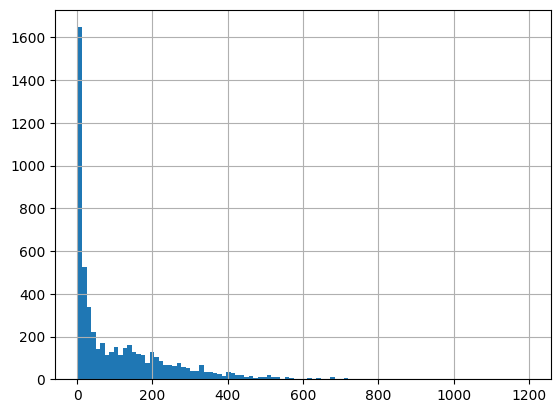

In [38]:
per_train.relevant_candidates.apply(len).hist(bins=100)

In [39]:
per_train.relevant_candidates.apply(len).describe()

count    5577.000000
mean      114.246907
std       142.107660
min         1.000000
25%         8.000000
50%        52.000000
75%       176.000000
max      1199.000000
Name: relevant_candidates, dtype: float64

In [35]:
base_train.text.describe()

count                                                   105
unique                                                  105
top       È a favore di una liberalizzazione completa de...
freq                                                      1
Name: text, dtype: object

In [36]:
base_dev.text.describe()

count                                                    30
unique                                                   30
top       Faut-il renforcer la protection contre le lice...
freq                                                      1
Name: text, dtype: object

In [16]:
corpus.columns

Index(['argument_id', 'argument', 'stance', 'topic', 'demographic_profile',
       'P_ID', 'gender', 'age', 'residence', 'civil_status', 'denomination',
       'education', 'political_spectrum', 'important_political_issues', 'rile',
       'galtan'],
      dtype='object')

In [20]:
args = [2019020,20190158,20190201,20190217,20190304,20190382,20190515,20190547,20190578,20190601,20190602,20190603,20190604,20190715,20190739,20190871,20190948,201901133,201901230,201901241,201901280,201901418,201901419,201901420,201901421,201901525,201901526,201901612,201901682,201901755,201901769,201901804,201901870,201902002,201902165,201902166,201902167,201902168,201902299,201902373,201902398,201902438,201902452,201902559,201902606,201902684,201902817,201902851,201902852,201902952,201902997,201903053,201903096,201903176,201903453,201903694,201903702,201903750,201903839,201903988,201904020,201904137,201904173,201904196,201904340,201904347,201904393,201904476,201904518,201904555,201904590,201904644,201904851,201904883,201904937,201905022,201905027,201905050,201905078,201905086,201905107,201905178,201905256,201905276,201905391,201905413,201905506,201905585,201905625,201905639,201905657,201905758,201905801,201905914,201905991,201906016,201906066,201906111,201906154,201906186,201906251,201906291,201906402,201906467,201906528,201906557,201906598,201906665,201906720,201906756,201906771,201906821,201906910,201906927,201906956,201906990,201907000,201907047,201907097,201907166,201907167,201907211,201907277,201907303,201907314,201907383,201907391,201907448,201907492,201907572,201907648,201907685,201907695,201907712,201907846,201908044,201908121,201908191,201908401,201908402,201908416,201908516,201908603,201908613,201908702,201908804,201908845,201908891,201908985,201909165,201909313,201909348,201909442,201909502,201909545,201909577,201909608,201909675,201909775,201909860,201909891,201909935,2019010007,2019010092,2019010105,2019010136,2019010198,2019010255,2019010298,2019010366,2019010388,2019010389,2019010575,2019010648,2019010649,2019010710,2019010767,2019010875,2019010950,2019011065,2019011084,2019011100,2019011128,2019011163,2019011180,2019011226,2019011308,2019011341,2019011382,2019011449,2019011469,2019011538,2019011565,2019011628,2019011678,2019011792,2019011964,2019011965,2019012004,2019012022,2019012055,2019012067,2019012152,2019012236,2019012266,2019012327,2019012364,2019012404,2019012452,2019012505,2019012640,2019012677,2019012787,2019012866,2019012893,2019012901,2019012908,2019012929,2019012959,2019012976,2019013017,2019013069,2019013119,2019013149,2019013226,2019013291,2019013332,2019013446,2019013485,2019013675,2019013715,2019013745,2019013805,2019013948,2019013949,2019013950,2019013951,2019014089,2019014117,2019014210,2019014262,2019014297,2019014395,2019014539,2019014618,2019014660,2019014722,2019014824,2019014880,2019015036,2019015037,2019015319,2019015368,2019015406,2019015407,2019015543,2019015600,2019015638,2019015666,2019015696,2019015787,2019015840,2019016123,2019016208,2019016221,2019016359,2019016480,2019016512,2019016605,2019016653,2019016809,2019016846,2019017069,2019017095,2019017206,2019017230,2019017307,2019017347,2019017374,2019017393,2019017564,2019017601,2019017627,2019017668,2019017819,2019017955,2019018061,2019018137,2019018171,2019018235,2019018296,2019018335,2019018423,2019018474,2019018553,2019018554,2019018717,2019018801,2019018994,2019019049,2019019112,2019019312,2019019600,2019019705,2019019706,2019019885,2019019911,2019019918,2019019934,2019020029,2019020106,2019020203,2019020216,2019020283,2019020329,2019020361,2019020422,2019020423,2019020656,2019020766,2019020809,2019021010,2019021016,2019021043,2019021261,2019021311,2019021353,2019021441,2019021470,2019021501,2019021502,2019021522,2019021547,2019021663,2019021737,2019021810,2019021857,2019021875,2019021966,2019022119,2019022144,2019022183,2019022194,2019022225,2019022276,2019022299,2019022324,2019022347,2019022361,2019022388,2019022420,2019022461,2019022515,2019022572,2019022768,2019022813,2019022850,2019022891,2019022956,2019023048,2019023062,2019023081,2019023108,2019023161,2019023206,2019023222,2019023258,2019023368,2019023435,2019023486,2019023522,2019023634,2019023736,2019023781,2019023871,2019023893,2019023927,2019023955,2019023985,2019024046,2019024131,2019024184,2019024192,2019024383,2019024407,2019024459,2019024590,2019024668,2019024686,2019024767,2019024803,2019024816,2019024938,2019024972,2019024992,2019025012,2019025160,2019025181,2019025261,2019025311,2019025382,2019025444,2019025480,2019025493,2019025507,2019025526,2019025543]
args2 = [20190515,20190547,20190602,201901010,201901419,201901525,201901526,201901527,201901682,201901804,201902166,201902344,201902759,201902851,201902852,201903053,201903176,201903555,201903750,201903839,201904020,201904494,201904518,201904834,201904851,201904883,201905009,201905027,201905050,201905107,201905215,201905256,201905335,201905391,201905413,201905506,201905585,201905639,201905801,201905991,201906079,201906154,201906251,201906598,201906617,201906821,201906956,201907047,201907166,201907314,201907383,201907448,201907572,201907712,201908097,201908166,201908401,201908553,201908702,201908927,201909284,201909642,201909654,201909708,201909775,2019010007,2019010289,2019010388,2019010389,2019010648,2019010710,2019010875,2019010950,2019010982,2019011065,2019011128,2019011226,2019011964,2019012193,2019012327,2019012353,2019012364,2019012537,2019012893,2019013190,2019013261,2019013353,2019013446,2019013675,2019013715,2019013949,2019014210,2019014539,2019014722,2019015209,2019016103,2019017044,2019017069,2019017307,2019017393,2019017601,2019017668,2019018061,2019018423,2019018801,2019019312,2019019918,2019019934,2019020283,2019020361,2019020656,2019020809,2019021031,2019021502,2019021547,2019021966,2019021994,2019022047,2019022166,2019022183,2019022225,2019022276,2019022388,2019022813,2019022850,2019022891,2019023108,2019023188,2019023486,2019023505,2019023522,2019023736,2019024019,2019024091,2019024323,2019024459,2019024816,2019024992]

In [21]:
sample = corpus[corpus.argument_id.isin(args)]
sample2 = corpus[corpus.argument_id.isin(args2)]

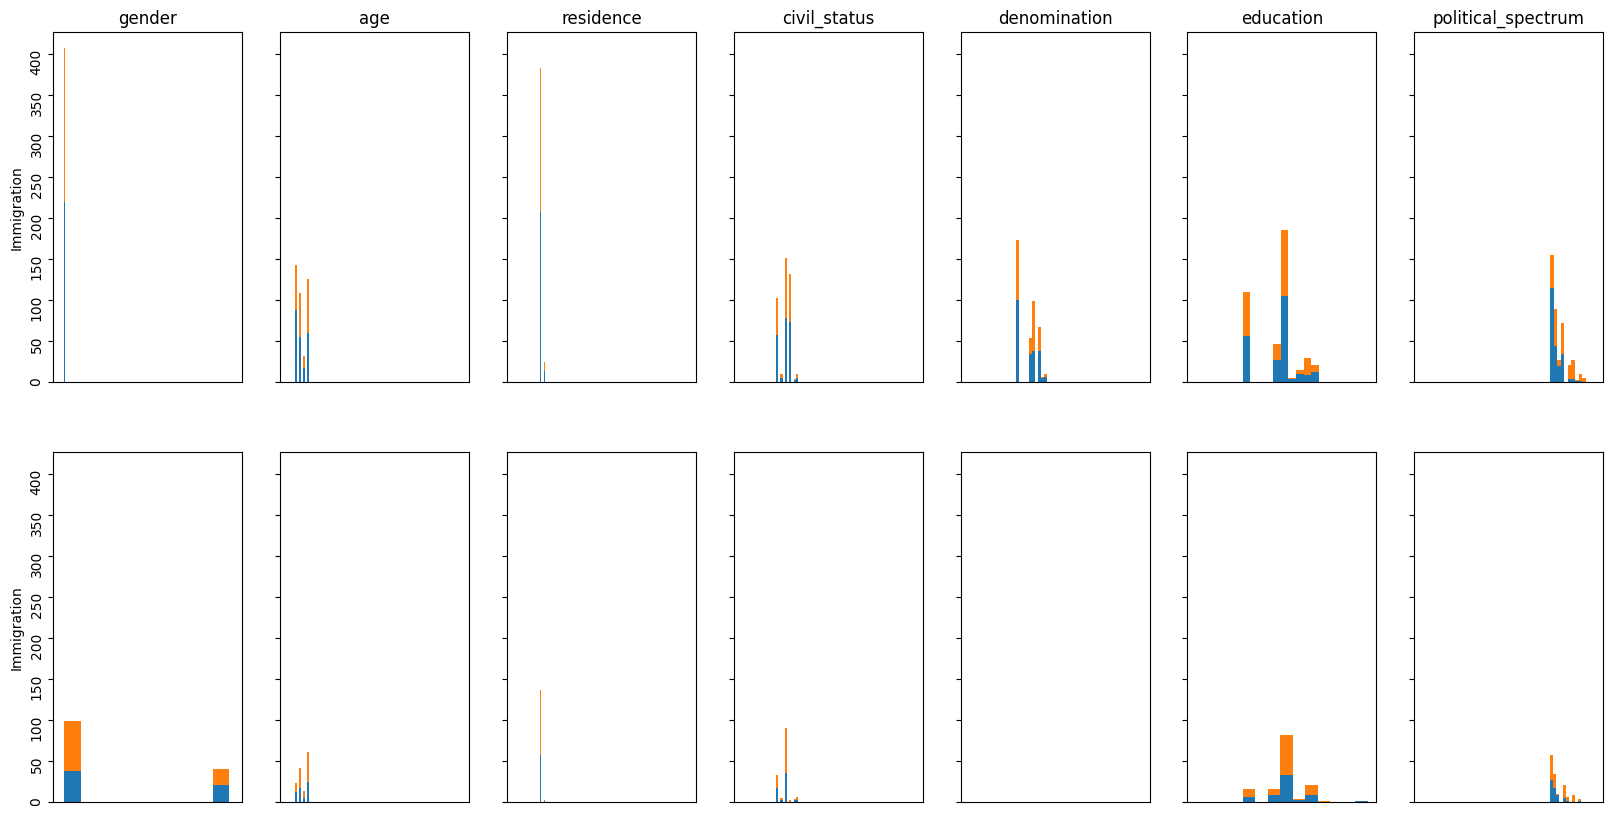

In [26]:
fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(20,10), sharex=True, sharey=True)
for i, top in enumerate([sample.topic.unique()[0], sample2.topic.unique()[0]]):
    for j, attr in enumerate(['gender', 'age', 'residence', 'civil_status', 'denomination', 'education', 'political_spectrum']):
        if i == 0:
            ax[i,j].hist((sample[(sample.topic == top) & (sample.stance == "FAVOR")][f"{attr}"], sample[(sample.topic == top) & (sample.stance == "AGAINST")][f"{attr}"]), stacked=True)
        else:
            ax[i,j].hist((sample2[(sample2.topic == top) & (sample2.stance == "FAVOR")][f"{attr}"], sample2[(sample2.topic == top) & (sample2.stance == "AGAINST")][f"{attr}"]), stacked=True)
        ax[i,j].set_xticklabels
        ax[i,j].tick_params(labelrotation=90)
        if i !=9:
            ax[i,j].set_xticks([], [])
        if i == 0:
            ax[i,j].set_title(f"{attr}")
        if j == 0:
            ax[i,j].set_ylabel(f"{top}")
            

In [27]:
sample2.denomination.describe()

count                                      138
unique                                       1
top       Evangelischreformiert/protestantisch
freq                                       138
Name: denomination, dtype: object